In [34]:
!ls ../caueeg/

abnormal-no-overlap.json annotation.xlsx          dementia.json
abnormal.json            conn_data                event
annotation.json          dementia-no-overlap.json signal


In [35]:
import json
f = open('../caueeg/abnormal.json')
data_files = json.load(f)
f.close()

In [36]:
data_files["train_split"][0]

{'serial': '01258',
 'age': 77,
 'symptom': ['dementia', 'vd', 'sivd'],
 'class_name': 'Abnormal',
 'class_label': 1}

In [37]:
idx2label = {}
for file_idx in data_files["train_split"]:
    idx2label[file_idx["serial"]] = file_idx["class_label"]
for file_idx in data_files["test_split"]:
    idx2label[file_idx["serial"]] = file_idx["class_label"]
for file_idx in data_files["validation_split"]:
    idx2label[file_idx["serial"]] = file_idx["class_label"]

In [38]:
len(data_files["train_split"])

1107

In [39]:
len(data_files["test_split"])

136

In [40]:
len(data_files["validation_split"])

136

In [41]:
import glob, os
files = []
for file in glob.glob("../caueeg/signal/edf/*.edf"):
    files.append(file)
print(len(files))

1379


In [42]:
import glob, os
test_data_files = []
for file_name in data_files["test_split"]:
    test_data_files.append("../caueeg/signal/edf/"+file_name["serial"]+".edf")
print(len(test_data_files))

train_data_files = []
for file_name in data_files["train_split"]:
    train_data_files.append("../caueeg/signal/edf/"+file_name["serial"]+".edf")
for file_name in data_files["validation_split"]:
    train_data_files.append("../caueeg/signal/edf/"+file_name["serial"]+".edf")
print(len(train_data_files))

136
1243


In [43]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.modules.module import Module
from sklearn.preprocessing import OneHotEncoder

In [12]:
import mne
import numpy as np

file = train_data_files[0]
data = mne.io.read_raw(file, verbose=False, preload=True)

data.filter(l_freq=0.5, h_freq=47, verbose=False)
data = data.get_data()*1e6
data.shape

(21, 183400)

In [69]:
import mne
from tqdm import tqdm
from statsmodels.tsa.stattools import grangercausalitytests
import random
import numpy as np
from scipy.signal import savgol_filter
from scipy import signal
import cv2
from numpy import *
from scipy.stats import iqr
from scipy.integrate import simps
from scipy.stats import entropy
from scipy.signal import medfilt
from scipy.stats import differential_entropy, norm
from scipy import fftpack
import antropy as ant


def calcGrangerCausality(eegData,ii,jj):
    #eegData = np.diff(eegData)
    gc_avg = []
    for epoch_idx, epoch in enumerate(eegData):
        if epoch_idx%2 == 0:
            X = np.vstack([epoch[ii,:],epoch[jj,:]]).T
            gc = grangercausalitytests(X, 1, addconst=True, verbose=False)[1][0]['ssr_ftest'][1]
            gc_avg.append(gc)
    gc_avg = np.mean(gc_avg)
    return gc_avg

def get_label(file):
    idx = file.split("/")[-1][:-4]
    label = idx2label[idx]
    if label == 0:
        return [0]
    elif label == 1:
        return [1]


def lyapunov(x):
    return np.mean(np.log(np.abs(np.gradient(x))))


def build_data(raw_data, bands=False):
    
    eeg_data = []
    labels = []
    lengths = []
    groups = []
    i = 0
    fs = 100
    
    data_features = []
    data_labels = []
    data_graphs = []
    
    for file in tqdm(raw_data):
        
        #get label
        label = get_label(file)
        data_labels.append(label)
        
        #node features
        sample_features = []
        data = mne.io.read_raw(file, verbose=False, preload=True)
        ch_names = data.ch_names
        #data.resample(sfreq=100)
        data.filter(l_freq=0.5, h_freq=40, verbose=False).resample(sfreq=fs)
        data_epochs = mne.make_fixed_length_epochs(data, duration=1, overlap=0, verbose=False)
        data = data.get_data()
        data_epochs = data_epochs.get_data()
        if data_epochs.shape[0] > 20:
            data_epochs = data_epochs[:20]

        gc = []
        for i in range(21):
            gc1 = []
            for j in range(21):
                gc1.append(calcGrangerCausality(data_epochs, i, j))
            gc.append(gc1)
        data_graphs.append(gc)    
        
        """
        ch_features = []    
        # freq domain features
        sf = 256
        win = 4 * sf # win size 4 seconds * sampling freq
        # delta (0.5–4 Hz), theta (4–8 Hz), alpha (8–13 Hz), beta (13–30 Hz), and gamma (30–... Hz).
        freq_ranges = [[0.5, 4], [4, 8], [8, 13], [13, 30], [30, 47]]
        for ch in data:
            
            ch_features.append(differential_entropy(ch))
        
            ly = lyapunov(ch)
            #ch_features.append(ly)
        
            entropy = ant.perm_entropy(ch, normalize=True)
            ch_features.append(entropy)
        
            entropy = ant.spectral_entropy(ch, sf=100, method='welch', normalize=True)
            ch_features.append(entropy)
        
            mobility = ant.hjorth_params(ch)
            ch_features.append(mobility[0])
            ch_features.append(mobility[1])
        
            zero_cross_count = ant.num_zerocross(ch)
            ch_features.append(zero_cross_count)
            
            
            if bands:
                # freq domain features
                for freq_band in freq_ranges:
                
                    # differential entropy
                    sos = signal.butter(10, (freq_band[0], freq_band[1]), 'bandpass', fs=1000, output='sos')
                    filtered_ch = signal.sosfilt(sos, ch) 
                    ch_features.append(differential_entropy(filtered_ch))

                    # lyapunov features
                    ch_features.append(lyapunov(filtered_ch))

                    # Permutation entropy
                    entropy = ant.perm_entropy(filtered_ch, normalize=True)
                    ch_features.append(entropy)

                    # Spectral entropy
                    entropy = ant.spectral_entropy(filtered_ch, sf=100, method='welch', normalize=True)
                    ch_features.append(entropy)

                    # Hjorth mobility and complexity
                    mobility = ant.hjorth_params(filtered_ch)
                    ch_features.append(mobility[0])
                    ch_features.append(mobility[1])

                    corr = np.correlate(filtered_ch, filtered_ch)
                    ch_features.append(corr[0])

                    # Number of zero-crossings
                    zero_cross_count = ant.num_zerocross(filtered_ch)
                    ch_features.append(zero_cross_count)

                    # power spectrum
                    freqs, psd = signal.welch(ch, sf, nperseg=win)
                    idx_freq_band = np.logical_and(freqs >= freq_band[0], freqs < freq_band[1])
                    # Frequency resolution
                    freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25
                    # Compute the absolute power by approximating the area under the curve
                    band_power = simps(psd[idx_freq_band], dx=freq_res)
                    #power_band_.append(band_power)
                    ch_features.append(band_power)
                
            
            sample_features.append(ch_features)
            ch_features = []
            """
        data_features.append(sample_features)
        
    data_features = np.array(data_features)
    data_labels = np.array(data_labels)
    data_graphs = np.array(data_graphs)
    
    return data_features, data_graphs, data_labels

In [70]:
#%%capture
np.random.seed(42)
train_X, train_graphs, train_y = build_data(train_data_files, True)
test_X, test_graphs, test_y = build_data(test_data_files, True)

  0%|                                                                        | 0/1243 [00:00<?, ?it/s]

Using data from preloaded Raw for 917 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  0%|                                                              | 1/1243 [00:05<1:49:21,  5.28s/it]

Using data from preloaded Raw for 882 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  0%|                                                              | 2/1243 [00:10<1:45:08,  5.08s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  0%|▏                                                             | 3/1243 [00:15<1:44:28,  5.06s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  0%|▏                                                             | 4/1243 [00:20<1:43:23,  5.01s/it]

Using data from preloaded Raw for 623 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  0%|▏                                                             | 5/1243 [00:24<1:41:32,  4.92s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  0%|▎                                                             | 6/1243 [00:29<1:40:39,  4.88s/it]

Using data from preloaded Raw for 364 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  1%|▎                                                             | 7/1243 [00:34<1:40:20,  4.87s/it]

Using data from preloaded Raw for 1071 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  1%|▍                                                             | 8/1243 [00:39<1:40:24,  4.88s/it]

Using data from preloaded Raw for 1064 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  1%|▍                                                             | 9/1243 [00:44<1:40:19,  4.88s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  1%|▍                                                            | 10/1243 [00:49<1:39:55,  4.86s/it]

Using data from preloaded Raw for 784 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  1%|▌                                                            | 11/1243 [00:53<1:39:18,  4.84s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  1%|▌                                                            | 12/1243 [00:58<1:39:04,  4.83s/it]

Using data from preloaded Raw for 889 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  1%|▋                                                            | 13/1243 [01:03<1:39:52,  4.87s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  1%|▋                                                            | 14/1243 [01:08<1:39:36,  4.86s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  1%|▋                                                            | 15/1243 [01:13<1:39:19,  4.85s/it]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  1%|▊                                                            | 16/1243 [01:18<1:38:49,  4.83s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  1%|▊                                                            | 17/1243 [01:23<1:38:46,  4.83s/it]

Using data from preloaded Raw for 938 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  1%|▉                                                            | 18/1243 [01:27<1:38:37,  4.83s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  2%|▉                                                            | 19/1243 [01:32<1:38:45,  4.84s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  2%|▉                                                            | 20/1243 [01:37<1:38:28,  4.83s/it]

Using data from preloaded Raw for 497 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  2%|█                                                            | 21/1243 [01:42<1:38:06,  4.82s/it]

Using data from preloaded Raw for 868 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  2%|█                                                            | 22/1243 [01:47<1:38:51,  4.86s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  2%|█▏                                                           | 23/1243 [01:52<1:38:08,  4.83s/it]

Using data from preloaded Raw for 672 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  2%|█▏                                                           | 24/1243 [01:56<1:38:09,  4.83s/it]

Using data from preloaded Raw for 896 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  2%|█▏                                                           | 25/1243 [02:01<1:38:50,  4.87s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  2%|█▎                                                           | 26/1243 [02:06<1:38:22,  4.85s/it]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  2%|█▎                                                           | 27/1243 [02:11<1:38:35,  4.86s/it]

Using data from preloaded Raw for 952 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  2%|█▎                                                           | 28/1243 [02:16<1:38:18,  4.85s/it]

Using data from preloaded Raw for 1211 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  2%|█▍                                                           | 29/1243 [02:21<1:38:36,  4.87s/it]

Using data from preloaded Raw for 819 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  2%|█▍                                                           | 30/1243 [02:26<1:37:44,  4.83s/it]

Using data from preloaded Raw for 938 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  2%|█▌                                                           | 31/1243 [02:30<1:37:46,  4.84s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  3%|█▌                                                           | 32/1243 [02:35<1:37:52,  4.85s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  3%|█▌                                                           | 33/1243 [02:40<1:37:14,  4.82s/it]

Using data from preloaded Raw for 784 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  3%|█▋                                                           | 34/1243 [02:45<1:36:54,  4.81s/it]

Using data from preloaded Raw for 623 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  3%|█▋                                                           | 35/1243 [02:50<1:36:18,  4.78s/it]

Using data from preloaded Raw for 987 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  3%|█▊                                                           | 36/1243 [02:54<1:36:29,  4.80s/it]

Using data from preloaded Raw for 889 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  3%|█▊                                                           | 37/1243 [02:59<1:36:26,  4.80s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  3%|█▊                                                           | 38/1243 [03:04<1:37:19,  4.85s/it]

Using data from preloaded Raw for 917 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  3%|█▉                                                           | 39/1243 [03:09<1:37:11,  4.84s/it]

Using data from preloaded Raw for 987 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  3%|█▉                                                           | 40/1243 [03:14<1:36:50,  4.83s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  3%|██                                                           | 41/1243 [03:19<1:36:33,  4.82s/it]

Using data from preloaded Raw for 987 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  3%|██                                                           | 42/1243 [03:23<1:36:14,  4.81s/it]

Using data from preloaded Raw for 469 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  3%|██                                                           | 43/1243 [03:28<1:35:31,  4.78s/it]

Using data from preloaded Raw for 651 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  4%|██▏                                                          | 44/1243 [03:33<1:35:22,  4.77s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  4%|██▏                                                          | 45/1243 [03:38<1:35:34,  4.79s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  4%|██▎                                                          | 46/1243 [03:42<1:35:27,  4.78s/it]

Using data from preloaded Raw for 882 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  4%|██▎                                                          | 47/1243 [03:47<1:35:14,  4.78s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  4%|██▎                                                          | 48/1243 [03:52<1:35:11,  4.78s/it]

Using data from preloaded Raw for 924 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  4%|██▍                                                          | 49/1243 [03:57<1:35:14,  4.79s/it]

Using data from preloaded Raw for 721 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  4%|██▍                                                          | 50/1243 [04:02<1:38:01,  4.93s/it]

Using data from preloaded Raw for 889 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  4%|██▌                                                          | 51/1243 [04:07<1:37:35,  4.91s/it]

Using data from preloaded Raw for 301 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  4%|██▌                                                          | 52/1243 [04:12<1:36:12,  4.85s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  4%|██▌                                                          | 53/1243 [04:16<1:36:14,  4.85s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  4%|██▋                                                          | 54/1243 [04:21<1:35:32,  4.82s/it]

Using data from preloaded Raw for 819 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  4%|██▋                                                          | 55/1243 [04:26<1:34:58,  4.80s/it]

Using data from preloaded Raw for 938 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  5%|██▋                                                          | 56/1243 [04:31<1:34:57,  4.80s/it]

Using data from preloaded Raw for 784 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  5%|██▊                                                          | 57/1243 [04:36<1:35:35,  4.84s/it]

Using data from preloaded Raw for 882 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  5%|██▊                                                          | 58/1243 [04:40<1:35:20,  4.83s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  5%|██▉                                                          | 59/1243 [04:45<1:34:21,  4.78s/it]

Using data from preloaded Raw for 784 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  5%|██▉                                                          | 60/1243 [04:50<1:34:08,  4.77s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  5%|██▉                                                          | 61/1243 [04:55<1:33:57,  4.77s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  5%|███                                                          | 62/1243 [04:59<1:33:39,  4.76s/it]

Using data from preloaded Raw for 924 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  5%|███                                                          | 63/1243 [05:04<1:34:24,  4.80s/it]

Using data from preloaded Raw for 1085 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  5%|███▏                                                         | 64/1243 [05:09<1:34:54,  4.83s/it]

Using data from preloaded Raw for 882 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  5%|███▏                                                         | 65/1243 [05:14<1:34:38,  4.82s/it]

Using data from preloaded Raw for 525 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  5%|███▏                                                         | 66/1243 [05:19<1:36:46,  4.93s/it]

Using data from preloaded Raw for 651 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  5%|███▎                                                         | 67/1243 [05:24<1:37:49,  4.99s/it]

Using data from preloaded Raw for 651 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  5%|███▎                                                         | 68/1243 [05:29<1:38:37,  5.04s/it]

Using data from preloaded Raw for 868 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  6%|███▍                                                         | 69/1243 [05:35<1:39:51,  5.10s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  6%|███▍                                                         | 70/1243 [05:40<1:40:14,  5.13s/it]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  6%|███▍                                                         | 71/1243 [05:45<1:40:09,  5.13s/it]

Using data from preloaded Raw for 784 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  6%|███▌                                                         | 72/1243 [05:50<1:40:12,  5.13s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  6%|███▌                                                         | 73/1243 [05:55<1:40:05,  5.13s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  6%|███▋                                                         | 74/1243 [06:01<1:40:43,  5.17s/it]

Using data from preloaded Raw for 889 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  6%|███▋                                                         | 75/1243 [06:06<1:41:16,  5.20s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  6%|███▋                                                         | 76/1243 [06:11<1:41:04,  5.20s/it]

Using data from preloaded Raw for 1057 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  6%|███▊                                                         | 77/1243 [06:16<1:41:11,  5.21s/it]

Using data from preloaded Raw for 959 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  6%|███▊                                                         | 78/1243 [06:21<1:40:47,  5.19s/it]

Using data from preloaded Raw for 651 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  6%|███▉                                                         | 79/1243 [06:27<1:40:18,  5.17s/it]

Using data from preloaded Raw for 595 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  6%|███▉                                                         | 80/1243 [06:32<1:39:58,  5.16s/it]

Using data from preloaded Raw for 616 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  7%|███▉                                                         | 81/1243 [06:37<1:39:54,  5.16s/it]

Using data from preloaded Raw for 973 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  7%|████                                                         | 82/1243 [06:42<1:40:13,  5.18s/it]

Using data from preloaded Raw for 896 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  7%|████                                                         | 83/1243 [06:47<1:40:01,  5.17s/it]

Using data from preloaded Raw for 1092 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  7%|████                                                         | 84/1243 [06:53<1:42:26,  5.30s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  7%|████▏                                                        | 85/1243 [06:58<1:43:12,  5.35s/it]

Using data from preloaded Raw for 763 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  7%|████▏                                                        | 86/1243 [07:04<1:42:33,  5.32s/it]

Using data from preloaded Raw for 784 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  7%|████▎                                                        | 87/1243 [07:11<1:52:15,  5.83s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  7%|████▎                                                        | 88/1243 [07:16<1:48:32,  5.64s/it]

Using data from preloaded Raw for 672 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  7%|████▎                                                        | 89/1243 [07:21<1:45:51,  5.50s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  7%|████▍                                                        | 90/1243 [07:26<1:43:58,  5.41s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  7%|████▍                                                        | 91/1243 [07:31<1:42:19,  5.33s/it]

Using data from preloaded Raw for 784 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  7%|████▌                                                        | 92/1243 [07:37<1:41:53,  5.31s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  7%|████▌                                                        | 93/1243 [07:42<1:40:53,  5.26s/it]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  8%|████▌                                                        | 94/1243 [07:47<1:40:20,  5.24s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  8%|████▋                                                        | 95/1243 [07:52<1:40:04,  5.23s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  8%|████▋                                                        | 96/1243 [07:57<1:39:55,  5.23s/it]

Using data from preloaded Raw for 917 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  8%|████▊                                                        | 97/1243 [08:02<1:39:41,  5.22s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  8%|████▊                                                        | 98/1243 [08:08<1:39:39,  5.22s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  8%|████▊                                                        | 99/1243 [08:13<1:39:28,  5.22s/it]

Using data from preloaded Raw for 728 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  8%|████▊                                                       | 100/1243 [08:18<1:39:13,  5.21s/it]

Using data from preloaded Raw for 623 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  8%|████▉                                                       | 101/1243 [08:23<1:38:32,  5.18s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  8%|████▉                                                       | 102/1243 [08:28<1:38:37,  5.19s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  8%|████▉                                                       | 103/1243 [08:34<1:38:50,  5.20s/it]

Using data from preloaded Raw for 658 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  8%|█████                                                       | 104/1243 [08:39<1:38:41,  5.20s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  8%|█████                                                       | 105/1243 [08:44<1:38:30,  5.19s/it]

Using data from preloaded Raw for 735 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  9%|█████                                                       | 106/1243 [08:49<1:38:23,  5.19s/it]

Using data from preloaded Raw for 812 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  9%|█████▏                                                      | 107/1243 [08:54<1:38:45,  5.22s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  9%|█████▏                                                      | 108/1243 [09:00<1:40:20,  5.30s/it]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  9%|█████▎                                                      | 109/1243 [09:05<1:40:14,  5.30s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  9%|█████▎                                                      | 110/1243 [09:11<1:39:37,  5.28s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  9%|█████▎                                                      | 111/1243 [09:16<1:38:45,  5.23s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  9%|█████▍                                                      | 112/1243 [09:21<1:38:20,  5.22s/it]

Using data from preloaded Raw for 469 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  9%|█████▍                                                      | 113/1243 [09:26<1:37:34,  5.18s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  9%|█████▌                                                      | 114/1243 [09:31<1:37:26,  5.18s/it]

Using data from preloaded Raw for 616 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  9%|█████▌                                                      | 115/1243 [09:36<1:37:09,  5.17s/it]

Using data from preloaded Raw for 917 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  9%|█████▌                                                      | 116/1243 [09:41<1:37:22,  5.18s/it]

Using data from preloaded Raw for 728 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  9%|█████▋                                                      | 117/1243 [09:47<1:37:14,  5.18s/it]

Using data from preloaded Raw for 966 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  9%|█████▋                                                      | 118/1243 [09:52<1:37:26,  5.20s/it]

Using data from preloaded Raw for 882 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 10%|█████▋                                                      | 119/1243 [09:57<1:37:01,  5.18s/it]

Using data from preloaded Raw for 896 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 10%|█████▊                                                      | 120/1243 [10:02<1:37:06,  5.19s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 10%|█████▊                                                      | 121/1243 [10:07<1:37:33,  5.22s/it]

Using data from preloaded Raw for 889 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 10%|█████▉                                                      | 122/1243 [10:13<1:37:25,  5.21s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 10%|█████▉                                                      | 123/1243 [10:18<1:37:14,  5.21s/it]

Using data from preloaded Raw for 728 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 10%|█████▉                                                      | 124/1243 [10:23<1:36:58,  5.20s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 10%|██████                                                      | 125/1243 [10:28<1:36:25,  5.17s/it]

Using data from preloaded Raw for 924 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 10%|██████                                                      | 126/1243 [10:33<1:36:44,  5.20s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 10%|██████▏                                                     | 127/1243 [10:39<1:36:41,  5.20s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 10%|██████▏                                                     | 128/1243 [10:44<1:36:14,  5.18s/it]

Using data from preloaded Raw for 805 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 10%|██████▏                                                     | 129/1243 [10:49<1:36:15,  5.18s/it]

Using data from preloaded Raw for 721 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 10%|██████▎                                                     | 130/1243 [10:54<1:36:05,  5.18s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 11%|██████▎                                                     | 131/1243 [10:59<1:35:52,  5.17s/it]

Using data from preloaded Raw for 616 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 11%|██████▎                                                     | 132/1243 [11:04<1:35:41,  5.17s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 11%|██████▍                                                     | 133/1243 [11:10<1:35:49,  5.18s/it]

Using data from preloaded Raw for 917 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 11%|██████▍                                                     | 134/1243 [11:15<1:35:53,  5.19s/it]

Using data from preloaded Raw for 973 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 11%|██████▌                                                     | 135/1243 [11:20<1:35:56,  5.20s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 11%|██████▌                                                     | 136/1243 [11:25<1:35:46,  5.19s/it]

Using data from preloaded Raw for 581 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 11%|██████▌                                                     | 137/1243 [11:30<1:35:16,  5.17s/it]

Using data from preloaded Raw for 525 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 11%|██████▋                                                     | 138/1243 [11:36<1:35:00,  5.16s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 11%|██████▋                                                     | 139/1243 [11:41<1:35:06,  5.17s/it]

Using data from preloaded Raw for 623 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 11%|██████▊                                                     | 140/1243 [11:46<1:34:44,  5.15s/it]

Using data from preloaded Raw for 924 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 11%|██████▊                                                     | 141/1243 [11:51<1:35:04,  5.18s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 11%|██████▊                                                     | 142/1243 [11:56<1:34:38,  5.16s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 12%|██████▉                                                     | 143/1243 [12:01<1:34:42,  5.17s/it]

Using data from preloaded Raw for 938 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 12%|██████▉                                                     | 144/1243 [12:07<1:35:02,  5.19s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 12%|██████▉                                                     | 145/1243 [12:12<1:34:42,  5.17s/it]

Using data from preloaded Raw for 1351 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 12%|███████                                                     | 146/1243 [12:17<1:35:36,  5.23s/it]

Using data from preloaded Raw for 693 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 12%|███████                                                     | 147/1243 [12:22<1:35:08,  5.21s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 12%|███████▏                                                    | 148/1243 [12:27<1:34:55,  5.20s/it]

Using data from preloaded Raw for 896 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 12%|███████▏                                                    | 149/1243 [12:33<1:34:51,  5.20s/it]

Using data from preloaded Raw for 749 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 12%|███████▏                                                    | 150/1243 [12:38<1:34:31,  5.19s/it]

Using data from preloaded Raw for 651 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 12%|███████▎                                                    | 151/1243 [12:43<1:34:05,  5.17s/it]

Using data from preloaded Raw for 966 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 12%|███████▎                                                    | 152/1243 [12:48<1:33:53,  5.16s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 12%|███████▍                                                    | 153/1243 [12:54<1:39:24,  5.47s/it]

Using data from preloaded Raw for 749 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 12%|███████▍                                                    | 154/1243 [13:01<1:47:02,  5.90s/it]

Using data from preloaded Raw for 469 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 12%|███████▍                                                    | 155/1243 [13:08<1:52:19,  6.19s/it]

Using data from preloaded Raw for 882 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 13%|███████▌                                                    | 156/1243 [13:15<1:56:21,  6.42s/it]

Using data from preloaded Raw for 756 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 13%|███████▌                                                    | 157/1243 [13:21<1:54:24,  6.32s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 13%|███████▋                                                    | 158/1243 [13:27<1:52:59,  6.25s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 13%|███████▋                                                    | 159/1243 [13:32<1:46:11,  5.88s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 13%|███████▋                                                    | 160/1243 [13:37<1:41:02,  5.60s/it]

Using data from preloaded Raw for 938 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 13%|███████▊                                                    | 161/1243 [13:42<1:37:54,  5.43s/it]

Using data from preloaded Raw for 700 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 13%|███████▊                                                    | 162/1243 [13:47<1:35:11,  5.28s/it]

Using data from preloaded Raw for 812 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 13%|███████▊                                                    | 163/1243 [13:52<1:33:31,  5.20s/it]

Using data from preloaded Raw for 581 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 13%|███████▉                                                    | 164/1243 [13:57<1:32:35,  5.15s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 13%|███████▉                                                    | 165/1243 [14:02<1:32:01,  5.12s/it]

Using data from preloaded Raw for 371 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 13%|████████                                                    | 166/1243 [14:07<1:30:34,  5.05s/it]

Using data from preloaded Raw for 770 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 13%|████████                                                    | 167/1243 [14:12<1:30:21,  5.04s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 14%|████████                                                    | 168/1243 [14:17<1:30:05,  5.03s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 14%|████████▏                                                   | 169/1243 [14:22<1:29:19,  4.99s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 14%|████████▏                                                   | 170/1243 [14:27<1:29:10,  4.99s/it]

Using data from preloaded Raw for 665 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 14%|████████▎                                                   | 171/1243 [14:32<1:28:53,  4.97s/it]

Using data from preloaded Raw for 889 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 14%|████████▎                                                   | 172/1243 [14:37<1:29:22,  5.01s/it]

Using data from preloaded Raw for 952 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 14%|████████▎                                                   | 173/1243 [14:42<1:29:49,  5.04s/it]

Using data from preloaded Raw for 1008 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 14%|████████▍                                                   | 174/1243 [14:47<1:29:29,  5.02s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 14%|████████▍                                                   | 175/1243 [14:52<1:28:57,  5.00s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 14%|████████▍                                                   | 176/1243 [14:57<1:28:46,  4.99s/it]

Using data from preloaded Raw for 784 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 14%|████████▌                                                   | 177/1243 [15:02<1:28:34,  4.99s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 14%|████████▌                                                   | 178/1243 [15:07<1:28:43,  5.00s/it]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 14%|████████▋                                                   | 179/1243 [15:12<1:28:43,  5.00s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 14%|████████▋                                                   | 180/1243 [15:17<1:28:56,  5.02s/it]

Using data from preloaded Raw for 511 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 15%|████████▋                                                   | 181/1243 [15:22<1:28:08,  4.98s/it]

Using data from preloaded Raw for 952 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 15%|████████▊                                                   | 182/1243 [15:27<1:28:14,  4.99s/it]

Using data from preloaded Raw for 805 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 15%|████████▊                                                   | 183/1243 [15:32<1:28:08,  4.99s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 15%|████████▉                                                   | 184/1243 [15:37<1:28:10,  5.00s/it]

Using data from preloaded Raw for 931 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 15%|████████▉                                                   | 185/1243 [15:42<1:28:20,  5.01s/it]

Using data from preloaded Raw for 959 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 15%|████████▉                                                   | 186/1243 [15:47<1:28:05,  5.00s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 15%|█████████                                                   | 187/1243 [15:52<1:27:58,  5.00s/it]

Using data from preloaded Raw for 959 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 15%|█████████                                                   | 188/1243 [15:57<1:27:54,  5.00s/it]

Using data from preloaded Raw for 889 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 15%|█████████                                                   | 189/1243 [16:02<1:28:29,  5.04s/it]

Using data from preloaded Raw for 644 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 15%|█████████▏                                                  | 190/1243 [16:07<1:27:57,  5.01s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 15%|█████████▏                                                  | 191/1243 [16:12<1:28:00,  5.02s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 15%|█████████▎                                                  | 192/1243 [16:17<1:27:49,  5.01s/it]

Using data from preloaded Raw for 784 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 16%|█████████▎                                                  | 193/1243 [16:22<1:27:34,  5.00s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 16%|█████████▎                                                  | 194/1243 [16:27<1:27:15,  4.99s/it]

Using data from preloaded Raw for 917 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 16%|█████████▍                                                  | 195/1243 [16:32<1:27:13,  4.99s/it]

Using data from preloaded Raw for 378 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 16%|█████████▍                                                  | 196/1243 [16:37<1:26:41,  4.97s/it]

Using data from preloaded Raw for 651 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 16%|█████████▌                                                  | 197/1243 [16:42<1:26:30,  4.96s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 16%|█████████▌                                                  | 198/1243 [16:47<1:26:34,  4.97s/it]

Using data from preloaded Raw for 595 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 16%|█████████▌                                                  | 199/1243 [16:52<1:26:30,  4.97s/it]

Using data from preloaded Raw for 616 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 16%|█████████▋                                                  | 200/1243 [16:57<1:26:16,  4.96s/it]

Using data from preloaded Raw for 1239 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 16%|█████████▋                                                  | 201/1243 [17:02<1:27:48,  5.06s/it]

Using data from preloaded Raw for 763 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 16%|█████████▊                                                  | 202/1243 [17:07<1:27:41,  5.05s/it]

Using data from preloaded Raw for 952 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 16%|█████████▊                                                  | 203/1243 [17:12<1:27:27,  5.05s/it]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 16%|█████████▊                                                  | 204/1243 [17:17<1:27:04,  5.03s/it]

Using data from preloaded Raw for 616 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 16%|█████████▉                                                  | 205/1243 [17:22<1:26:12,  4.98s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 17%|█████████▉                                                  | 206/1243 [17:27<1:26:17,  4.99s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 17%|█████████▉                                                  | 207/1243 [17:32<1:25:52,  4.97s/it]

Using data from preloaded Raw for 658 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 17%|██████████                                                  | 208/1243 [17:37<1:25:47,  4.97s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 17%|██████████                                                  | 209/1243 [17:42<1:25:43,  4.97s/it]

Using data from preloaded Raw for 693 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 17%|██████████▏                                                 | 210/1243 [17:47<1:25:29,  4.97s/it]

Using data from preloaded Raw for 791 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 17%|██████████▏                                                 | 211/1243 [17:52<1:26:27,  5.03s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 17%|██████████▏                                                 | 212/1243 [17:57<1:26:16,  5.02s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 17%|██████████▎                                                 | 213/1243 [18:02<1:26:16,  5.03s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 17%|██████████▎                                                 | 214/1243 [18:07<1:26:50,  5.06s/it]

Using data from preloaded Raw for 616 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 17%|██████████▍                                                 | 215/1243 [18:12<1:26:17,  5.04s/it]

Using data from preloaded Raw for 952 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 17%|██████████▍                                                 | 216/1243 [18:17<1:26:08,  5.03s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 17%|██████████▍                                                 | 217/1243 [18:22<1:25:18,  4.99s/it]

Using data from preloaded Raw for 931 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 18%|██████████▌                                                 | 218/1243 [18:27<1:25:30,  5.01s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 18%|██████████▌                                                 | 219/1243 [18:32<1:25:27,  5.01s/it]

Using data from preloaded Raw for 616 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 18%|██████████▌                                                 | 220/1243 [18:37<1:25:24,  5.01s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 18%|██████████▋                                                 | 221/1243 [18:42<1:25:18,  5.01s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 18%|██████████▋                                                 | 222/1243 [18:47<1:25:02,  5.00s/it]

Using data from preloaded Raw for 987 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 18%|██████████▊                                                 | 223/1243 [18:52<1:25:10,  5.01s/it]

Using data from preloaded Raw for 798 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 18%|██████████▊                                                 | 224/1243 [18:57<1:25:02,  5.01s/it]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 18%|██████████▊                                                 | 225/1243 [19:02<1:24:54,  5.00s/it]

Using data from preloaded Raw for 938 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 18%|██████████▉                                                 | 226/1243 [19:07<1:24:52,  5.01s/it]

Using data from preloaded Raw for 826 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 18%|██████████▉                                                 | 227/1243 [19:12<1:25:27,  5.05s/it]

Using data from preloaded Raw for 546 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 18%|███████████                                                 | 228/1243 [19:18<1:26:26,  5.11s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 18%|███████████                                                 | 229/1243 [19:23<1:26:56,  5.14s/it]

Using data from preloaded Raw for 931 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 19%|███████████                                                 | 230/1243 [19:28<1:27:08,  5.16s/it]

Using data from preloaded Raw for 721 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 19%|███████████▏                                                | 231/1243 [19:33<1:27:28,  5.19s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 19%|███████████▏                                                | 232/1243 [19:39<1:27:32,  5.20s/it]

Using data from preloaded Raw for 623 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 19%|███████████▏                                                | 233/1243 [19:44<1:27:11,  5.18s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 19%|███████████▎                                                | 234/1243 [19:49<1:26:53,  5.17s/it]

Using data from preloaded Raw for 791 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 19%|███████████▎                                                | 235/1243 [19:54<1:26:57,  5.18s/it]

Using data from preloaded Raw for 490 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 19%|███████████▍                                                | 236/1243 [19:59<1:26:59,  5.18s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 19%|███████████▍                                                | 237/1243 [20:04<1:27:27,  5.22s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 19%|███████████▍                                                | 238/1243 [20:10<1:27:14,  5.21s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 19%|███████████▌                                                | 239/1243 [20:15<1:27:04,  5.20s/it]

Using data from preloaded Raw for 476 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 19%|███████████▌                                                | 240/1243 [20:20<1:26:57,  5.20s/it]

Using data from preloaded Raw for 616 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 19%|███████████▋                                                | 241/1243 [20:25<1:26:44,  5.19s/it]

Using data from preloaded Raw for 658 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 19%|███████████▋                                                | 242/1243 [20:30<1:26:42,  5.20s/it]

Using data from preloaded Raw for 1218 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 20%|███████████▋                                                | 243/1243 [20:36<1:27:13,  5.23s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 20%|███████████▊                                                | 244/1243 [20:41<1:27:14,  5.24s/it]

Using data from preloaded Raw for 882 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 20%|███████████▊                                                | 245/1243 [20:46<1:27:03,  5.23s/it]

Using data from preloaded Raw for 651 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 20%|███████████▊                                                | 246/1243 [20:51<1:26:41,  5.22s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 20%|███████████▉                                                | 247/1243 [20:57<1:26:23,  5.20s/it]

Using data from preloaded Raw for 714 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 20%|███████████▉                                                | 248/1243 [21:02<1:26:10,  5.20s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 20%|████████████                                                | 249/1243 [21:07<1:26:26,  5.22s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 20%|████████████                                                | 250/1243 [21:12<1:26:15,  5.21s/it]

Using data from preloaded Raw for 938 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 20%|████████████                                                | 251/1243 [21:17<1:26:22,  5.22s/it]

Using data from preloaded Raw for 686 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 20%|████████████▏                                               | 252/1243 [21:23<1:26:14,  5.22s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 20%|████████████▏                                               | 253/1243 [21:28<1:26:13,  5.23s/it]

Using data from preloaded Raw for 560 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 20%|████████████▎                                               | 254/1243 [21:33<1:25:54,  5.21s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 21%|████████████▎                                               | 255/1243 [21:38<1:25:41,  5.20s/it]

Using data from preloaded Raw for 616 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 21%|████████████▎                                               | 256/1243 [21:43<1:25:26,  5.19s/it]

Using data from preloaded Raw for 616 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 21%|████████████▍                                               | 257/1243 [21:49<1:25:19,  5.19s/it]

Using data from preloaded Raw for 651 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 21%|████████████▍                                               | 258/1243 [21:54<1:25:03,  5.18s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 21%|████████████▌                                               | 259/1243 [22:00<1:27:42,  5.35s/it]

Using data from preloaded Raw for 616 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 21%|████████████▌                                               | 260/1243 [22:06<1:32:08,  5.62s/it]

Using data from preloaded Raw for 616 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 21%|████████████▌                                               | 261/1243 [22:12<1:34:47,  5.79s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 21%|████████████▋                                               | 262/1243 [22:18<1:35:38,  5.85s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 21%|████████████▋                                               | 263/1243 [22:24<1:36:23,  5.90s/it]

Using data from preloaded Raw for 588 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 21%|████████████▋                                               | 264/1243 [22:29<1:30:43,  5.56s/it]

Using data from preloaded Raw for 959 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 21%|████████████▊                                               | 265/1243 [22:34<1:27:30,  5.37s/it]

Using data from preloaded Raw for 658 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 21%|████████████▊                                               | 266/1243 [22:39<1:27:15,  5.36s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 21%|████████████▉                                               | 267/1243 [22:45<1:31:08,  5.60s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 22%|████████████▉                                               | 268/1243 [22:52<1:34:42,  5.83s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 22%|████████████▉                                               | 269/1243 [22:57<1:32:47,  5.72s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 22%|█████████████                                               | 270/1243 [23:03<1:33:28,  5.76s/it]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 22%|█████████████                                               | 271/1243 [23:08<1:29:08,  5.50s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 22%|█████████████▏                                              | 272/1243 [23:13<1:25:34,  5.29s/it]

Using data from preloaded Raw for 882 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 22%|█████████████▏                                              | 273/1243 [23:17<1:22:58,  5.13s/it]

Using data from preloaded Raw for 945 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 22%|█████████████▏                                              | 274/1243 [23:22<1:21:11,  5.03s/it]

Using data from preloaded Raw for 784 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 22%|█████████████▎                                              | 275/1243 [23:27<1:19:49,  4.95s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 22%|█████████████▎                                              | 276/1243 [23:32<1:19:11,  4.91s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 22%|█████████████▎                                              | 277/1243 [23:37<1:18:52,  4.90s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 22%|█████████████▍                                              | 278/1243 [23:41<1:18:50,  4.90s/it]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 22%|█████████████▍                                              | 279/1243 [23:46<1:17:57,  4.85s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 23%|█████████████▌                                              | 280/1243 [23:51<1:17:34,  4.83s/it]

Using data from preloaded Raw for 868 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 23%|█████████████▌                                              | 281/1243 [23:56<1:17:04,  4.81s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 23%|█████████████▌                                              | 282/1243 [24:01<1:17:39,  4.85s/it]

Using data from preloaded Raw for 994 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 23%|█████████████▋                                              | 283/1243 [24:06<1:18:06,  4.88s/it]

Using data from preloaded Raw for 616 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 23%|█████████████▋                                              | 284/1243 [24:10<1:17:18,  4.84s/it]

Using data from preloaded Raw for 917 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 23%|█████████████▊                                              | 285/1243 [24:15<1:17:15,  4.84s/it]

Using data from preloaded Raw for 574 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 23%|█████████████▊                                              | 286/1243 [24:20<1:16:28,  4.79s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 23%|█████████████▊                                              | 287/1243 [24:25<1:16:08,  4.78s/it]

Using data from preloaded Raw for 364 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 23%|█████████████▉                                              | 288/1243 [24:29<1:15:43,  4.76s/it]

Using data from preloaded Raw for 924 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 23%|█████████████▉                                              | 289/1243 [24:34<1:16:05,  4.79s/it]

Using data from preloaded Raw for 567 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 23%|█████████████▉                                              | 290/1243 [24:39<1:15:40,  4.76s/it]

Using data from preloaded Raw for 924 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 23%|██████████████                                              | 291/1243 [24:44<1:15:57,  4.79s/it]

Using data from preloaded Raw for 917 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 23%|██████████████                                              | 292/1243 [24:49<1:18:41,  4.96s/it]

Using data from preloaded Raw for 959 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 24%|██████████████▏                                             | 293/1243 [24:55<1:20:24,  5.08s/it]

Using data from preloaded Raw for 791 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 24%|██████████████▏                                             | 294/1243 [25:00<1:24:15,  5.33s/it]

Using data from preloaded Raw for 483 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 24%|██████████████▏                                             | 295/1243 [25:06<1:23:34,  5.29s/it]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 24%|██████████████▎                                             | 296/1243 [25:11<1:21:42,  5.18s/it]

Using data from preloaded Raw for 917 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 24%|██████████████▎                                             | 297/1243 [25:15<1:19:56,  5.07s/it]

Using data from preloaded Raw for 434 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 24%|██████████████▍                                             | 298/1243 [25:20<1:18:05,  4.96s/it]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 24%|██████████████▍                                             | 299/1243 [25:25<1:17:23,  4.92s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 24%|██████████████▍                                             | 300/1243 [25:30<1:18:27,  4.99s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 24%|██████████████▌                                             | 301/1243 [25:35<1:18:29,  5.00s/it]

Using data from preloaded Raw for 686 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 24%|██████████████▌                                             | 302/1243 [25:40<1:17:21,  4.93s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 24%|██████████████▋                                             | 303/1243 [25:45<1:16:38,  4.89s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 24%|██████████████▋                                             | 304/1243 [25:49<1:15:36,  4.83s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 25%|██████████████▋                                             | 305/1243 [25:54<1:15:11,  4.81s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 25%|██████████████▊                                             | 306/1243 [25:59<1:14:54,  4.80s/it]

Using data from preloaded Raw for 623 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 25%|██████████████▊                                             | 307/1243 [26:04<1:15:32,  4.84s/it]

Using data from preloaded Raw for 980 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 25%|██████████████▊                                             | 308/1243 [26:09<1:16:03,  4.88s/it]

Using data from preloaded Raw for 826 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 25%|██████████████▉                                             | 309/1243 [26:14<1:16:17,  4.90s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 25%|██████████████▉                                             | 310/1243 [26:19<1:16:56,  4.95s/it]

Using data from preloaded Raw for 728 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 25%|███████████████                                             | 311/1243 [26:24<1:16:22,  4.92s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 25%|███████████████                                             | 312/1243 [26:28<1:15:50,  4.89s/it]

Using data from preloaded Raw for 917 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 25%|███████████████                                             | 313/1243 [26:33<1:16:17,  4.92s/it]

Using data from preloaded Raw for 1246 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 25%|███████████████▏                                            | 314/1243 [26:39<1:17:25,  5.00s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 25%|███████████████▏                                            | 315/1243 [26:44<1:18:28,  5.07s/it]

Using data from preloaded Raw for 651 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 25%|███████████████▎                                            | 316/1243 [26:49<1:16:43,  4.97s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 26%|███████████████▎                                            | 317/1243 [26:54<1:16:59,  4.99s/it]

Using data from preloaded Raw for 819 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 26%|███████████████▎                                            | 318/1243 [26:58<1:15:43,  4.91s/it]

Using data from preloaded Raw for 819 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 26%|███████████████▍                                            | 319/1243 [27:04<1:17:10,  5.01s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 26%|███████████████▍                                            | 320/1243 [27:08<1:16:14,  4.96s/it]

Using data from preloaded Raw for 917 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 26%|███████████████▍                                            | 321/1243 [27:13<1:15:38,  4.92s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 26%|███████████████▌                                            | 322/1243 [27:18<1:14:31,  4.86s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 26%|███████████████▌                                            | 323/1243 [27:23<1:14:05,  4.83s/it]

Using data from preloaded Raw for 637 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 26%|███████████████▋                                            | 324/1243 [27:27<1:13:33,  4.80s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 26%|███████████████▋                                            | 325/1243 [27:32<1:13:06,  4.78s/it]

Using data from preloaded Raw for 448 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 26%|███████████████▋                                            | 326/1243 [27:37<1:12:57,  4.77s/it]

Using data from preloaded Raw for 420 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 26%|███████████████▊                                            | 327/1243 [27:42<1:12:37,  4.76s/it]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 26%|███████████████▊                                            | 328/1243 [27:46<1:12:31,  4.76s/it]

Using data from preloaded Raw for 1064 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 26%|███████████████▉                                            | 329/1243 [27:51<1:12:42,  4.77s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 27%|███████████████▉                                            | 330/1243 [27:56<1:12:28,  4.76s/it]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 27%|███████████████▉                                            | 331/1243 [28:01<1:13:18,  4.82s/it]

Using data from preloaded Raw for 623 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 27%|████████████████                                            | 332/1243 [28:06<1:13:20,  4.83s/it]

Using data from preloaded Raw for 770 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 27%|████████████████                                            | 333/1243 [28:11<1:13:51,  4.87s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 27%|████████████████                                            | 334/1243 [28:16<1:13:29,  4.85s/it]

Using data from preloaded Raw for 1071 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 27%|████████████████▏                                           | 335/1243 [28:20<1:13:11,  4.84s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 27%|████████████████▏                                           | 336/1243 [28:25<1:14:19,  4.92s/it]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 27%|████████████████▎                                           | 337/1243 [28:30<1:13:39,  4.88s/it]

Using data from preloaded Raw for 665 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 27%|████████████████▎                                           | 338/1243 [28:35<1:13:49,  4.89s/it]

Using data from preloaded Raw for 574 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 27%|████████████████▎                                           | 339/1243 [28:40<1:12:52,  4.84s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 27%|████████████████▍                                           | 340/1243 [28:45<1:12:31,  4.82s/it]

Using data from preloaded Raw for 651 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 27%|████████████████▍                                           | 341/1243 [28:49<1:11:45,  4.77s/it]

Using data from preloaded Raw for 378 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 28%|████████████████▌                                           | 342/1243 [28:54<1:11:11,  4.74s/it]

Using data from preloaded Raw for 784 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 28%|████████████████▌                                           | 343/1243 [28:59<1:11:10,  4.74s/it]

Using data from preloaded Raw for 812 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 28%|████████████████▌                                           | 344/1243 [29:04<1:11:55,  4.80s/it]

Using data from preloaded Raw for 1008 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 28%|████████████████▋                                           | 345/1243 [29:09<1:11:55,  4.81s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 28%|████████████████▋                                           | 346/1243 [29:15<1:18:01,  5.22s/it]

Using data from preloaded Raw for 518 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 28%|████████████████▋                                           | 347/1243 [29:20<1:17:43,  5.21s/it]

Using data from preloaded Raw for 623 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 28%|████████████████▊                                           | 348/1243 [29:25<1:17:30,  5.20s/it]

Using data from preloaded Raw for 630 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 28%|████████████████▊                                           | 349/1243 [29:30<1:17:22,  5.19s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 28%|████████████████▉                                           | 350/1243 [29:36<1:17:50,  5.23s/it]

Using data from preloaded Raw for 826 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 28%|████████████████▉                                           | 351/1243 [29:41<1:17:49,  5.23s/it]

Using data from preloaded Raw for 987 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 28%|████████████████▉                                           | 352/1243 [29:46<1:17:47,  5.24s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 28%|█████████████████                                           | 353/1243 [29:51<1:17:49,  5.25s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 28%|█████████████████                                           | 354/1243 [29:57<1:18:28,  5.30s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 29%|█████████████████▏                                          | 355/1243 [30:02<1:18:08,  5.28s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 29%|█████████████████▏                                          | 356/1243 [30:07<1:18:24,  5.30s/it]

Using data from preloaded Raw for 637 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 29%|█████████████████▏                                          | 357/1243 [30:13<1:17:57,  5.28s/it]

Using data from preloaded Raw for 924 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 29%|█████████████████▎                                          | 358/1243 [30:18<1:17:43,  5.27s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 29%|█████████████████▎                                          | 359/1243 [30:23<1:17:23,  5.25s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 29%|█████████████████▍                                          | 360/1243 [30:28<1:17:10,  5.24s/it]

Using data from preloaded Raw for 1001 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 29%|█████████████████▍                                          | 361/1243 [30:34<1:17:25,  5.27s/it]

Using data from preloaded Raw for 1162 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 29%|█████████████████▍                                          | 362/1243 [30:39<1:17:30,  5.28s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 29%|█████████████████▌                                          | 363/1243 [30:44<1:18:08,  5.33s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 29%|█████████████████▌                                          | 364/1243 [30:49<1:17:09,  5.27s/it]

Using data from preloaded Raw for 742 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 29%|█████████████████▌                                          | 365/1243 [30:55<1:19:05,  5.40s/it]

Using data from preloaded Raw for 686 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 29%|█████████████████▋                                          | 366/1243 [31:00<1:18:30,  5.37s/it]

Using data from preloaded Raw for 889 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 30%|█████████████████▋                                          | 367/1243 [31:06<1:18:02,  5.35s/it]

Using data from preloaded Raw for 917 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 30%|█████████████████▊                                          | 368/1243 [31:11<1:18:35,  5.39s/it]

Using data from preloaded Raw for 987 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 30%|█████████████████▊                                          | 369/1243 [31:17<1:18:46,  5.41s/it]

Using data from preloaded Raw for 784 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 30%|█████████████████▊                                          | 370/1243 [31:22<1:18:55,  5.42s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 30%|█████████████████▉                                          | 371/1243 [31:28<1:19:09,  5.45s/it]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 30%|█████████████████▉                                          | 372/1243 [31:33<1:18:34,  5.41s/it]

Using data from preloaded Raw for 826 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 30%|██████████████████                                          | 373/1243 [31:38<1:17:42,  5.36s/it]

Using data from preloaded Raw for 798 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 30%|██████████████████                                          | 374/1243 [31:43<1:17:02,  5.32s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 30%|██████████████████                                          | 375/1243 [31:49<1:16:44,  5.31s/it]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 30%|██████████████████▏                                         | 376/1243 [31:54<1:16:24,  5.29s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 30%|██████████████████▏                                         | 377/1243 [31:59<1:15:42,  5.24s/it]

Using data from preloaded Raw for 805 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 30%|██████████████████▏                                         | 378/1243 [32:04<1:15:51,  5.26s/it]

Using data from preloaded Raw for 364 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 30%|██████████████████▎                                         | 379/1243 [32:10<1:15:09,  5.22s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 31%|██████████████████▎                                         | 380/1243 [32:15<1:15:09,  5.22s/it]

Using data from preloaded Raw for 476 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 31%|██████████████████▍                                         | 381/1243 [32:20<1:14:36,  5.19s/it]

Using data from preloaded Raw for 469 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 31%|██████████████████▍                                         | 382/1243 [32:25<1:14:13,  5.17s/it]

Using data from preloaded Raw for 476 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 31%|██████████████████▍                                         | 383/1243 [32:30<1:13:57,  5.16s/it]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 31%|██████████████████▌                                         | 384/1243 [32:36<1:15:24,  5.27s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 31%|██████████████████▌                                         | 385/1243 [32:41<1:16:10,  5.33s/it]

Using data from preloaded Raw for 917 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 31%|██████████████████▋                                         | 386/1243 [32:47<1:16:38,  5.37s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 31%|██████████████████▋                                         | 387/1243 [32:52<1:15:44,  5.31s/it]

Using data from preloaded Raw for 1036 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 31%|██████████████████▋                                         | 388/1243 [32:57<1:16:23,  5.36s/it]

Using data from preloaded Raw for 1204 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 31%|██████████████████▊                                         | 389/1243 [33:03<1:17:10,  5.42s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 31%|██████████████████▊                                         | 390/1243 [33:08<1:17:21,  5.44s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 31%|██████████████████▊                                         | 391/1243 [33:14<1:17:36,  5.47s/it]

Using data from preloaded Raw for 637 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 32%|██████████████████▉                                         | 392/1243 [33:19<1:16:13,  5.37s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 32%|██████████████████▉                                         | 393/1243 [33:24<1:16:29,  5.40s/it]

Using data from preloaded Raw for 833 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 32%|███████████████████                                         | 394/1243 [33:30<1:15:47,  5.36s/it]

Using data from preloaded Raw for 749 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 32%|███████████████████                                         | 395/1243 [33:35<1:15:20,  5.33s/it]

Using data from preloaded Raw for 868 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 32%|███████████████████                                         | 396/1243 [33:40<1:14:57,  5.31s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 32%|███████████████████▏                                        | 397/1243 [33:45<1:14:30,  5.28s/it]

Using data from preloaded Raw for 882 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 32%|███████████████████▏                                        | 398/1243 [33:51<1:14:16,  5.27s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 32%|███████████████████▎                                        | 399/1243 [33:56<1:14:43,  5.31s/it]

Using data from preloaded Raw for 931 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 32%|███████████████████▎                                        | 400/1243 [34:02<1:15:31,  5.38s/it]

Using data from preloaded Raw for 945 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 32%|███████████████████▎                                        | 401/1243 [34:07<1:15:27,  5.38s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 32%|███████████████████▍                                        | 402/1243 [34:12<1:15:49,  5.41s/it]

Using data from preloaded Raw for 637 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 32%|███████████████████▍                                        | 403/1243 [34:18<1:14:38,  5.33s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 33%|███████████████████▌                                        | 404/1243 [34:23<1:13:46,  5.28s/it]

Using data from preloaded Raw for 714 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 33%|███████████████████▌                                        | 405/1243 [34:28<1:13:17,  5.25s/it]

Using data from preloaded Raw for 945 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 33%|███████████████████▌                                        | 406/1243 [34:33<1:13:18,  5.26s/it]

Using data from preloaded Raw for 574 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 33%|███████████████████▋                                        | 407/1243 [34:38<1:12:51,  5.23s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 33%|███████████████████▋                                        | 408/1243 [34:44<1:12:48,  5.23s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 33%|███████████████████▋                                        | 409/1243 [34:49<1:13:36,  5.30s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 33%|███████████████████▊                                        | 410/1243 [34:55<1:14:08,  5.34s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 33%|███████████████████▊                                        | 411/1243 [35:00<1:13:22,  5.29s/it]

Using data from preloaded Raw for 546 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 33%|███████████████████▉                                        | 412/1243 [35:05<1:12:55,  5.27s/it]

Using data from preloaded Raw for 721 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 33%|███████████████████▉                                        | 413/1243 [35:10<1:12:44,  5.26s/it]

Using data from preloaded Raw for 931 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 33%|███████████████████▉                                        | 414/1243 [35:15<1:12:35,  5.25s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 33%|████████████████████                                        | 415/1243 [35:21<1:14:39,  5.41s/it]

Using data from preloaded Raw for 707 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 33%|████████████████████                                        | 416/1243 [35:27<1:17:58,  5.66s/it]

Using data from preloaded Raw for 553 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 34%|████████████████████▏                                       | 417/1243 [35:34<1:23:12,  6.04s/it]

Using data from preloaded Raw for 518 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 34%|████████████████████▏                                       | 418/1243 [35:40<1:19:43,  5.80s/it]

Using data from preloaded Raw for 490 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 34%|████████████████████▏                                       | 419/1243 [35:45<1:17:01,  5.61s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 34%|████████████████████▎                                       | 420/1243 [35:50<1:14:29,  5.43s/it]

Using data from preloaded Raw for 623 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 34%|████████████████████▎                                       | 421/1243 [35:55<1:12:21,  5.28s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 34%|████████████████████▎                                       | 422/1243 [36:00<1:11:15,  5.21s/it]

Using data from preloaded Raw for 938 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 34%|████████████████████▍                                       | 423/1243 [36:05<1:10:43,  5.17s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 34%|████████████████████▍                                       | 424/1243 [36:10<1:09:42,  5.11s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 34%|████████████████████▌                                       | 425/1243 [36:15<1:09:41,  5.11s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 34%|████████████████████▌                                       | 426/1243 [36:20<1:09:08,  5.08s/it]

Using data from preloaded Raw for 1029 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 34%|████████████████████▌                                       | 427/1243 [36:25<1:08:44,  5.05s/it]

Using data from preloaded Raw for 791 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 34%|████████████████████▋                                       | 428/1243 [36:30<1:08:24,  5.04s/it]

Using data from preloaded Raw for 938 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 35%|████████████████████▋                                       | 429/1243 [36:35<1:08:27,  5.05s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 35%|████████████████████▊                                       | 430/1243 [36:40<1:08:10,  5.03s/it]

Using data from preloaded Raw for 364 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 35%|████████████████████▊                                       | 431/1243 [36:45<1:07:27,  4.98s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 35%|████████████████████▊                                       | 432/1243 [36:50<1:07:05,  4.96s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 35%|████████████████████▉                                       | 433/1243 [36:55<1:06:47,  4.95s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 35%|████████████████████▉                                       | 434/1243 [37:00<1:07:02,  4.97s/it]

Using data from preloaded Raw for 1022 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 35%|████████████████████▉                                       | 435/1243 [37:05<1:07:30,  5.01s/it]

Using data from preloaded Raw for 623 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 35%|█████████████████████                                       | 436/1243 [37:10<1:07:08,  4.99s/it]

Using data from preloaded Raw for 819 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 35%|█████████████████████                                       | 437/1243 [37:15<1:08:32,  5.10s/it]

Using data from preloaded Raw for 665 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 35%|█████████████████████▏                                      | 438/1243 [37:20<1:07:55,  5.06s/it]

Using data from preloaded Raw for 455 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 35%|█████████████████████▏                                      | 439/1243 [37:25<1:07:10,  5.01s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 35%|█████████████████████▏                                      | 440/1243 [37:30<1:07:58,  5.08s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 35%|█████████████████████▎                                      | 441/1243 [37:35<1:07:30,  5.05s/it]

Using data from preloaded Raw for 805 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 36%|█████████████████████▎                                      | 442/1243 [37:40<1:07:10,  5.03s/it]

Using data from preloaded Raw for 924 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 36%|█████████████████████▍                                      | 443/1243 [37:45<1:07:13,  5.04s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 36%|█████████████████████▍                                      | 444/1243 [37:50<1:06:57,  5.03s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 36%|█████████████████████▍                                      | 445/1243 [37:55<1:06:42,  5.02s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 36%|█████████████████████▌                                      | 446/1243 [38:00<1:06:54,  5.04s/it]

Using data from preloaded Raw for 882 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 36%|█████████████████████▌                                      | 447/1243 [38:05<1:07:21,  5.08s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 36%|█████████████████████▋                                      | 448/1243 [38:11<1:07:25,  5.09s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 36%|█████████████████████▋                                      | 449/1243 [38:16<1:06:53,  5.05s/it]

Using data from preloaded Raw for 1064 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 36%|█████████████████████▋                                      | 450/1243 [38:21<1:06:34,  5.04s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 36%|█████████████████████▊                                      | 451/1243 [38:26<1:06:14,  5.02s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 36%|█████████████████████▊                                      | 452/1243 [38:31<1:06:05,  5.01s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 36%|█████████████████████▊                                      | 453/1243 [38:36<1:05:54,  5.01s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 37%|█████████████████████▉                                      | 454/1243 [38:40<1:05:24,  4.97s/it]

Using data from preloaded Raw for 896 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 37%|█████████████████████▉                                      | 455/1243 [38:45<1:05:24,  4.98s/it]

Using data from preloaded Raw for 917 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 37%|██████████████████████                                      | 456/1243 [38:50<1:05:24,  4.99s/it]

Using data from preloaded Raw for 623 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 37%|██████████████████████                                      | 457/1243 [38:55<1:05:10,  4.98s/it]

Using data from preloaded Raw for 826 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 37%|██████████████████████                                      | 458/1243 [39:01<1:06:45,  5.10s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 37%|██████████████████████▏                                     | 459/1243 [39:06<1:09:02,  5.28s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 37%|██████████████████████▏                                     | 460/1243 [39:12<1:09:06,  5.30s/it]

Using data from preloaded Raw for 721 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 37%|██████████████████████▎                                     | 461/1243 [39:17<1:07:56,  5.21s/it]

Using data from preloaded Raw for 896 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 37%|██████████████████████▎                                     | 462/1243 [39:22<1:07:07,  5.16s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 37%|██████████████████████▎                                     | 463/1243 [39:27<1:06:10,  5.09s/it]

Using data from preloaded Raw for 413 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 37%|██████████████████████▍                                     | 464/1243 [39:32<1:05:33,  5.05s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 37%|██████████████████████▍                                     | 465/1243 [39:37<1:05:29,  5.05s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 37%|██████████████████████▍                                     | 466/1243 [39:42<1:05:23,  5.05s/it]

Using data from preloaded Raw for 931 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 38%|██████████████████████▌                                     | 467/1243 [39:47<1:05:08,  5.04s/it]

Using data from preloaded Raw for 1183 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 38%|██████████████████████▌                                     | 468/1243 [39:52<1:05:20,  5.06s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 38%|██████████████████████▋                                     | 469/1243 [39:57<1:05:01,  5.04s/it]

Using data from preloaded Raw for 868 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 38%|██████████████████████▋                                     | 470/1243 [40:02<1:05:05,  5.05s/it]

Using data from preloaded Raw for 889 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 38%|██████████████████████▋                                     | 471/1243 [40:07<1:05:30,  5.09s/it]

Using data from preloaded Raw for 441 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 38%|██████████████████████▊                                     | 472/1243 [40:12<1:05:11,  5.07s/it]

Using data from preloaded Raw for 784 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 38%|██████████████████████▊                                     | 473/1243 [40:17<1:05:03,  5.07s/it]

Using data from preloaded Raw for 868 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 38%|██████████████████████▉                                     | 474/1243 [40:22<1:04:48,  5.06s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 38%|██████████████████████▉                                     | 475/1243 [40:27<1:04:39,  5.05s/it]

Using data from preloaded Raw for 924 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 38%|██████████████████████▉                                     | 476/1243 [40:32<1:04:31,  5.05s/it]

Using data from preloaded Raw for 371 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 38%|███████████████████████                                     | 477/1243 [40:37<1:04:14,  5.03s/it]

Using data from preloaded Raw for 728 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 38%|███████████████████████                                     | 478/1243 [40:42<1:04:10,  5.03s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 39%|███████████████████████                                     | 479/1243 [40:47<1:03:50,  5.01s/it]

Using data from preloaded Raw for 658 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 39%|███████████████████████▏                                    | 480/1243 [40:52<1:03:36,  5.00s/it]

Using data from preloaded Raw for 896 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 39%|███████████████████████▏                                    | 481/1243 [40:57<1:03:46,  5.02s/it]

Using data from preloaded Raw for 973 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 39%|███████████████████████▎                                    | 482/1243 [41:03<1:05:27,  5.16s/it]

Using data from preloaded Raw for 938 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 39%|███████████████████████▎                                    | 483/1243 [41:08<1:06:03,  5.22s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 39%|███████████████████████▎                                    | 484/1243 [41:13<1:06:02,  5.22s/it]

Using data from preloaded Raw for 889 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 39%|███████████████████████▍                                    | 485/1243 [41:19<1:06:17,  5.25s/it]

Using data from preloaded Raw for 938 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 39%|███████████████████████▍                                    | 486/1243 [41:24<1:06:24,  5.26s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 39%|███████████████████████▌                                    | 487/1243 [41:29<1:06:35,  5.28s/it]

Using data from preloaded Raw for 889 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 39%|███████████████████████▌                                    | 488/1243 [41:35<1:06:43,  5.30s/it]

Using data from preloaded Raw for 784 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 39%|███████████████████████▌                                    | 489/1243 [41:40<1:06:33,  5.30s/it]

Using data from preloaded Raw for 966 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 39%|███████████████████████▋                                    | 490/1243 [41:45<1:06:29,  5.30s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 40%|███████████████████████▋                                    | 491/1243 [41:51<1:06:07,  5.28s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 40%|███████████████████████▋                                    | 492/1243 [41:56<1:05:47,  5.26s/it]

Using data from preloaded Raw for 938 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 40%|███████████████████████▊                                    | 493/1243 [42:01<1:05:58,  5.28s/it]

Using data from preloaded Raw for 791 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 40%|███████████████████████▊                                    | 494/1243 [42:07<1:06:20,  5.31s/it]

Using data from preloaded Raw for 693 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 40%|███████████████████████▉                                    | 495/1243 [42:12<1:06:11,  5.31s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 40%|███████████████████████▉                                    | 496/1243 [42:17<1:06:04,  5.31s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 40%|███████████████████████▉                                    | 497/1243 [42:22<1:05:57,  5.31s/it]

Using data from preloaded Raw for 546 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 40%|████████████████████████                                    | 498/1243 [42:28<1:05:34,  5.28s/it]

Using data from preloaded Raw for 483 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 40%|████████████████████████                                    | 499/1243 [42:33<1:05:20,  5.27s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 40%|████████████████████████▏                                   | 500/1243 [42:38<1:05:24,  5.28s/it]

Using data from preloaded Raw for 917 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 40%|████████████████████████▏                                   | 501/1243 [42:43<1:05:21,  5.28s/it]

Using data from preloaded Raw for 896 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 40%|████████████████████████▏                                   | 502/1243 [42:49<1:05:18,  5.29s/it]

Using data from preloaded Raw for 1197 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 40%|████████████████████████▎                                   | 503/1243 [42:54<1:05:17,  5.29s/it]

Using data from preloaded Raw for 672 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 41%|████████████████████████▎                                   | 504/1243 [42:59<1:05:15,  5.30s/it]

Using data from preloaded Raw for 693 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 41%|████████████████████████▍                                   | 505/1243 [43:05<1:05:55,  5.36s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 41%|████████████████████████▍                                   | 506/1243 [43:11<1:07:36,  5.50s/it]

Using data from preloaded Raw for 1043 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 41%|████████████████████████▍                                   | 507/1243 [43:16<1:06:56,  5.46s/it]

Using data from preloaded Raw for 637 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 41%|████████████████████████▌                                   | 508/1243 [43:21<1:06:01,  5.39s/it]

Using data from preloaded Raw for 504 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 41%|████████████████████████▌                                   | 509/1243 [43:27<1:05:12,  5.33s/it]

Using data from preloaded Raw for 623 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 41%|████████████████████████▌                                   | 510/1243 [43:32<1:04:50,  5.31s/it]

Using data from preloaded Raw for 924 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 41%|████████████████████████▋                                   | 511/1243 [43:37<1:05:01,  5.33s/it]

Using data from preloaded Raw for 798 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 41%|████████████████████████▋                                   | 512/1243 [43:42<1:04:47,  5.32s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 41%|████████████████████████▊                                   | 513/1243 [43:48<1:04:31,  5.30s/it]

Using data from preloaded Raw for 637 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 41%|████████████████████████▊                                   | 514/1243 [43:53<1:04:11,  5.28s/it]

Using data from preloaded Raw for 707 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 41%|████████████████████████▊                                   | 515/1243 [43:58<1:04:04,  5.28s/it]

Using data from preloaded Raw for 1183 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 42%|████████████████████████▉                                   | 516/1243 [44:04<1:04:16,  5.30s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 42%|████████████████████████▉                                   | 517/1243 [44:09<1:04:11,  5.31s/it]

Using data from preloaded Raw for 623 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 42%|█████████████████████████                                   | 518/1243 [44:14<1:03:52,  5.29s/it]

Using data from preloaded Raw for 917 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 42%|█████████████████████████                                   | 519/1243 [44:19<1:03:50,  5.29s/it]

Using data from preloaded Raw for 882 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 42%|█████████████████████████                                   | 520/1243 [44:25<1:03:41,  5.29s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 42%|█████████████████████████▏                                  | 521/1243 [44:30<1:03:38,  5.29s/it]

Using data from preloaded Raw for 931 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 42%|█████████████████████████▏                                  | 522/1243 [44:35<1:03:57,  5.32s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 42%|█████████████████████████▏                                  | 523/1243 [44:41<1:03:51,  5.32s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 42%|█████████████████████████▎                                  | 524/1243 [44:46<1:03:40,  5.31s/it]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 42%|█████████████████████████▎                                  | 525/1243 [44:51<1:03:29,  5.31s/it]

Using data from preloaded Raw for 882 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 42%|█████████████████████████▍                                  | 526/1243 [44:57<1:03:22,  5.30s/it]

Using data from preloaded Raw for 630 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 42%|█████████████████████████▍                                  | 527/1243 [45:02<1:02:59,  5.28s/it]

Using data from preloaded Raw for 721 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 42%|█████████████████████████▍                                  | 528/1243 [45:07<1:03:01,  5.29s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 43%|█████████████████████████▌                                  | 529/1243 [45:12<1:03:02,  5.30s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 43%|█████████████████████████▌                                  | 530/1243 [45:18<1:02:25,  5.25s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 43%|█████████████████████████▋                                  | 531/1243 [45:23<1:01:20,  5.17s/it]

Using data from preloaded Raw for 511 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 43%|█████████████████████████▋                                  | 532/1243 [45:28<1:00:22,  5.10s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 43%|█████████████████████████▋                                  | 533/1243 [45:33<1:03:08,  5.34s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 43%|█████████████████████████▊                                  | 534/1243 [45:38<1:01:50,  5.23s/it]

Using data from preloaded Raw for 1050 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 43%|█████████████████████████▊                                  | 535/1243 [45:43<1:01:03,  5.17s/it]

Using data from preloaded Raw for 1386 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 43%|█████████████████████████▊                                  | 536/1243 [45:49<1:00:49,  5.16s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 43%|█████████████████████████▉                                  | 537/1243 [45:54<1:00:05,  5.11s/it]

Using data from preloaded Raw for 777 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 43%|█████████████████████████▉                                  | 538/1243 [45:59<1:00:01,  5.11s/it]

Using data from preloaded Raw for 455 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 43%|██████████████████████████▉                                   | 539/1243 [46:04<59:51,  5.10s/it]

Using data from preloaded Raw for 945 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 43%|██████████████████████████▉                                   | 540/1243 [46:09<59:50,  5.11s/it]

Using data from preloaded Raw for 896 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 44%|██████████████████████████▉                                   | 541/1243 [46:14<59:52,  5.12s/it]

Using data from preloaded Raw for 462 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 44%|███████████████████████████                                   | 542/1243 [46:19<59:11,  5.07s/it]

Using data from preloaded Raw for 1232 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 44%|███████████████████████████                                   | 543/1243 [46:24<59:08,  5.07s/it]

Using data from preloaded Raw for 665 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 44%|███████████████████████████▏                                  | 544/1243 [46:29<58:56,  5.06s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 44%|███████████████████████████▏                                  | 545/1243 [46:34<59:01,  5.07s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 44%|███████████████████████████▏                                  | 546/1243 [46:39<58:55,  5.07s/it]

Using data from preloaded Raw for 553 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 44%|███████████████████████████▎                                  | 547/1243 [46:44<58:19,  5.03s/it]

Using data from preloaded Raw for 882 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 44%|███████████████████████████▎                                  | 548/1243 [46:49<58:13,  5.03s/it]

Using data from preloaded Raw for 490 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 44%|███████████████████████████▍                                  | 549/1243 [46:54<57:45,  4.99s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 44%|███████████████████████████▍                                  | 550/1243 [47:00<59:32,  5.16s/it]

Using data from preloaded Raw for 735 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 44%|██████████████████████████▌                                 | 551/1243 [47:05<1:00:38,  5.26s/it]

Using data from preloaded Raw for 1092 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 44%|██████████████████████████▋                                 | 552/1243 [47:11<1:01:18,  5.32s/it]

Using data from preloaded Raw for 868 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 44%|██████████████████████████▋                                 | 553/1243 [47:16<1:01:23,  5.34s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 45%|██████████████████████████▋                                 | 554/1243 [47:21<1:01:26,  5.35s/it]

Using data from preloaded Raw for 980 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 45%|██████████████████████████▊                                 | 555/1243 [47:27<1:01:36,  5.37s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 45%|██████████████████████████▊                                 | 556/1243 [47:32<1:02:24,  5.45s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 45%|██████████████████████████▉                                 | 557/1243 [47:38<1:02:05,  5.43s/it]

Using data from preloaded Raw for 896 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 45%|██████████████████████████▉                                 | 558/1243 [47:43<1:00:45,  5.32s/it]

Using data from preloaded Raw for 959 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 45%|███████████████████████████▉                                  | 559/1243 [47:48<59:33,  5.22s/it]

Using data from preloaded Raw for 868 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 45%|███████████████████████████▉                                  | 560/1243 [47:53<58:45,  5.16s/it]

Using data from preloaded Raw for 896 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 45%|███████████████████████████▉                                  | 561/1243 [47:58<58:18,  5.13s/it]

Using data from preloaded Raw for 1134 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 45%|████████████████████████████                                  | 562/1243 [48:03<58:25,  5.15s/it]

Using data from preloaded Raw for 665 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 45%|████████████████████████████                                  | 563/1243 [48:08<57:57,  5.11s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 45%|████████████████████████████▏                                 | 564/1243 [48:13<58:17,  5.15s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 45%|████████████████████████████▏                                 | 565/1243 [48:19<58:51,  5.21s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 46%|████████████████████████████▏                                 | 566/1243 [48:24<58:14,  5.16s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 46%|████████████████████████████▎                                 | 567/1243 [48:29<57:33,  5.11s/it]

Using data from preloaded Raw for 882 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 46%|████████████████████████████▎                                 | 568/1243 [48:34<57:33,  5.12s/it]

Using data from preloaded Raw for 616 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 46%|████████████████████████████▍                                 | 569/1243 [48:39<56:55,  5.07s/it]

Using data from preloaded Raw for 931 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 46%|████████████████████████████▍                                 | 570/1243 [48:44<56:42,  5.06s/it]

Using data from preloaded Raw for 623 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 46%|████████████████████████████▍                                 | 571/1243 [48:49<56:07,  5.01s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 46%|████████████████████████████▌                                 | 572/1243 [48:54<55:59,  5.01s/it]

Using data from preloaded Raw for 595 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 46%|████████████████████████████▌                                 | 573/1243 [48:59<55:37,  4.98s/it]

Using data from preloaded Raw for 623 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 46%|████████████████████████████▋                                 | 574/1243 [49:04<55:48,  5.00s/it]

Using data from preloaded Raw for 784 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 46%|████████████████████████████▋                                 | 575/1243 [49:09<55:39,  5.00s/it]

Using data from preloaded Raw for 924 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 46%|████████████████████████████▋                                 | 576/1243 [49:14<56:05,  5.05s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 46%|████████████████████████████▊                                 | 577/1243 [49:19<55:39,  5.01s/it]

Using data from preloaded Raw for 616 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 47%|████████████████████████████▊                                 | 578/1243 [49:24<55:20,  4.99s/it]

Using data from preloaded Raw for 917 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 47%|████████████████████████████▉                                 | 579/1243 [49:29<55:40,  5.03s/it]

Using data from preloaded Raw for 616 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 47%|████████████████████████████▉                                 | 580/1243 [49:34<56:39,  5.13s/it]

Using data from preloaded Raw for 966 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 47%|████████████████████████████▉                                 | 581/1243 [49:39<56:30,  5.12s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 47%|█████████████████████████████                                 | 582/1243 [49:44<55:47,  5.06s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 47%|█████████████████████████████                                 | 583/1243 [49:49<55:36,  5.06s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 47%|█████████████████████████████▏                                | 584/1243 [49:54<55:18,  5.04s/it]

Using data from preloaded Raw for 882 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 47%|█████████████████████████████▏                                | 585/1243 [49:59<55:25,  5.05s/it]

Using data from preloaded Raw for 931 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 47%|█████████████████████████████▏                                | 586/1243 [50:05<55:28,  5.07s/it]

Using data from preloaded Raw for 749 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 47%|█████████████████████████████▎                                | 587/1243 [50:10<55:30,  5.08s/it]

Using data from preloaded Raw for 882 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 47%|█████████████████████████████▎                                | 588/1243 [50:15<55:33,  5.09s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 47%|█████████████████████████████▍                                | 589/1243 [50:20<55:42,  5.11s/it]

Using data from preloaded Raw for 560 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 47%|█████████████████████████████▍                                | 590/1243 [50:25<56:03,  5.15s/it]

Using data from preloaded Raw for 707 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 48%|█████████████████████████████▍                                | 591/1243 [50:30<55:35,  5.12s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 48%|█████████████████████████████▌                                | 592/1243 [50:36<57:50,  5.33s/it]

Using data from preloaded Raw for 707 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 48%|█████████████████████████████▌                                | 593/1243 [50:42<58:22,  5.39s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 48%|█████████████████████████████▋                                | 594/1243 [50:47<58:20,  5.39s/it]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 48%|█████████████████████████████▋                                | 595/1243 [50:52<58:11,  5.39s/it]

Using data from preloaded Raw for 546 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 48%|█████████████████████████████▋                                | 596/1243 [50:58<57:59,  5.38s/it]

Using data from preloaded Raw for 812 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 48%|█████████████████████████████▊                                | 597/1243 [51:03<58:16,  5.41s/it]

Using data from preloaded Raw for 693 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 48%|█████████████████████████████▊                                | 598/1243 [51:09<58:22,  5.43s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 48%|████████████████████████████▉                               | 599/1243 [51:15<1:00:24,  5.63s/it]

Using data from preloaded Raw for 693 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 48%|████████████████████████████▉                               | 600/1243 [51:21<1:01:16,  5.72s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 48%|█████████████████████████████▉                                | 601/1243 [51:26<59:44,  5.58s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 48%|██████████████████████████████                                | 602/1243 [51:31<57:54,  5.42s/it]

Using data from preloaded Raw for 1036 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 49%|██████████████████████████████                                | 603/1243 [51:37<58:24,  5.48s/it]

Using data from preloaded Raw for 1148 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 49%|█████████████████████████████▏                              | 604/1243 [51:43<1:01:13,  5.75s/it]

Using data from preloaded Raw for 616 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 49%|█████████████████████████████▏                              | 605/1243 [51:49<1:02:27,  5.87s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 49%|█████████████████████████████▎                              | 606/1243 [51:55<1:01:35,  5.80s/it]

Using data from preloaded Raw for 819 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 49%|█████████████████████████████▎                              | 607/1243 [52:00<1:00:20,  5.69s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 49%|██████████████████████████████▎                               | 608/1243 [52:06<59:17,  5.60s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 49%|██████████████████████████████▍                               | 609/1243 [52:11<58:31,  5.54s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 49%|██████████████████████████████▍                               | 610/1243 [52:16<57:36,  5.46s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 49%|██████████████████████████████▍                               | 611/1243 [52:22<57:02,  5.42s/it]

Using data from preloaded Raw for 896 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 49%|██████████████████████████████▌                               | 612/1243 [52:27<56:48,  5.40s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 49%|██████████████████████████████▌                               | 613/1243 [52:32<55:53,  5.32s/it]

Using data from preloaded Raw for 616 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 49%|██████████████████████████████▋                               | 614/1243 [52:37<54:55,  5.24s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 49%|██████████████████████████████▋                               | 615/1243 [52:42<54:19,  5.19s/it]

Using data from preloaded Raw for 763 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 50%|██████████████████████████████▋                               | 616/1243 [52:47<53:48,  5.15s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 50%|██████████████████████████████▊                               | 617/1243 [52:52<53:26,  5.12s/it]

Using data from preloaded Raw for 917 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 50%|██████████████████████████████▊                               | 618/1243 [52:57<53:04,  5.09s/it]

Using data from preloaded Raw for 616 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 50%|██████████████████████████████▉                               | 619/1243 [53:02<52:36,  5.06s/it]

Using data from preloaded Raw for 917 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 50%|██████████████████████████████▉                               | 620/1243 [53:07<52:31,  5.06s/it]

Using data from preloaded Raw for 1008 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 50%|██████████████████████████████▉                               | 621/1243 [53:13<52:37,  5.08s/it]

Using data from preloaded Raw for 896 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 50%|███████████████████████████████                               | 622/1243 [53:18<52:22,  5.06s/it]

Using data from preloaded Raw for 616 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 50%|███████████████████████████████                               | 623/1243 [53:22<52:00,  5.03s/it]

Using data from preloaded Raw for 616 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 50%|███████████████████████████████                               | 624/1243 [53:28<51:49,  5.02s/it]

Using data from preloaded Raw for 924 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 50%|███████████████████████████████▏                              | 625/1243 [53:33<52:15,  5.07s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 50%|███████████████████████████████▏                              | 626/1243 [53:38<52:17,  5.08s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 50%|███████████████████████████████▎                              | 627/1243 [53:43<52:32,  5.12s/it]

Using data from preloaded Raw for 651 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 51%|███████████████████████████████▎                              | 628/1243 [53:48<51:49,  5.06s/it]

Using data from preloaded Raw for 938 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 51%|███████████████████████████████▎                              | 629/1243 [53:53<52:09,  5.10s/it]

Using data from preloaded Raw for 1036 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 51%|███████████████████████████████▍                              | 630/1243 [53:58<52:01,  5.09s/it]

Using data from preloaded Raw for 630 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 51%|███████████████████████████████▍                              | 631/1243 [54:03<51:43,  5.07s/it]

Using data from preloaded Raw for 868 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 51%|███████████████████████████████▌                              | 632/1243 [54:08<51:39,  5.07s/it]

Using data from preloaded Raw for 1260 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 51%|███████████████████████████████▌                              | 633/1243 [54:13<51:55,  5.11s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 51%|███████████████████████████████▌                              | 634/1243 [54:18<51:32,  5.08s/it]

Using data from preloaded Raw for 700 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 51%|███████████████████████████████▋                              | 635/1243 [54:23<51:14,  5.06s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 51%|███████████████████████████████▋                              | 636/1243 [54:29<51:05,  5.05s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 51%|███████████████████████████████▊                              | 637/1243 [54:34<51:30,  5.10s/it]

Using data from preloaded Raw for 630 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 51%|███████████████████████████████▊                              | 638/1243 [54:39<51:10,  5.07s/it]

Using data from preloaded Raw for 931 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 51%|███████████████████████████████▊                              | 639/1243 [54:44<51:49,  5.15s/it]

Using data from preloaded Raw for 966 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 51%|███████████████████████████████▉                              | 640/1243 [54:49<52:33,  5.23s/it]

Using data from preloaded Raw for 581 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 52%|███████████████████████████████▉                              | 641/1243 [54:56<55:36,  5.54s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 52%|████████████████████████████████                              | 642/1243 [55:02<56:37,  5.65s/it]

Using data from preloaded Raw for 616 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 52%|████████████████████████████████                              | 643/1243 [55:07<55:39,  5.57s/it]

Using data from preloaded Raw for 868 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 52%|████████████████████████████████                              | 644/1243 [55:13<55:16,  5.54s/it]

Using data from preloaded Raw for 896 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 52%|████████████████████████████████▏                             | 645/1243 [55:18<54:17,  5.45s/it]

Using data from preloaded Raw for 560 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 52%|████████████████████████████████▏                             | 646/1243 [55:23<52:47,  5.31s/it]

Using data from preloaded Raw for 658 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 52%|████████████████████████████████▎                             | 647/1243 [55:28<51:49,  5.22s/it]

Using data from preloaded Raw for 889 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 52%|████████████████████████████████▎                             | 648/1243 [55:33<51:51,  5.23s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 52%|████████████████████████████████▎                             | 649/1243 [55:38<51:13,  5.17s/it]

Using data from preloaded Raw for 917 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 52%|████████████████████████████████▍                             | 650/1243 [55:43<50:49,  5.14s/it]

Using data from preloaded Raw for 735 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 52%|████████████████████████████████▍                             | 651/1243 [55:48<50:39,  5.13s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 52%|████████████████████████████████▌                             | 652/1243 [55:53<50:16,  5.10s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 53%|████████████████████████████████▌                             | 653/1243 [55:58<50:07,  5.10s/it]

Using data from preloaded Raw for 546 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 53%|████████████████████████████████▌                             | 654/1243 [56:03<49:55,  5.09s/it]

Using data from preloaded Raw for 616 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 53%|████████████████████████████████▋                             | 655/1243 [56:09<50:15,  5.13s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 53%|████████████████████████████████▋                             | 656/1243 [56:14<50:54,  5.20s/it]

Using data from preloaded Raw for 819 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 53%|████████████████████████████████▊                             | 657/1243 [56:20<51:57,  5.32s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 53%|████████████████████████████████▊                             | 658/1243 [56:26<54:37,  5.60s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 53%|████████████████████████████████▊                             | 659/1243 [56:32<55:31,  5.71s/it]

Using data from preloaded Raw for 630 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 53%|████████████████████████████████▉                             | 660/1243 [56:37<53:44,  5.53s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 53%|████████████████████████████████▉                             | 661/1243 [56:43<54:51,  5.66s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 53%|█████████████████████████████████                             | 662/1243 [56:49<55:13,  5.70s/it]

Using data from preloaded Raw for 637 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 53%|█████████████████████████████████                             | 663/1243 [56:55<55:41,  5.76s/it]

Using data from preloaded Raw for 546 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 53%|█████████████████████████████████                             | 664/1243 [57:00<54:46,  5.68s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 53%|█████████████████████████████████▏                            | 665/1243 [57:06<55:14,  5.73s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 54%|█████████████████████████████████▏                            | 666/1243 [57:12<55:21,  5.76s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 54%|█████████████████████████████████▎                            | 667/1243 [57:17<53:49,  5.61s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 54%|█████████████████████████████████▎                            | 668/1243 [57:22<51:13,  5.35s/it]

Using data from preloaded Raw for 1015 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 54%|█████████████████████████████████▎                            | 669/1243 [57:27<49:36,  5.19s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 54%|█████████████████████████████████▍                            | 670/1243 [57:31<48:21,  5.06s/it]

Using data from preloaded Raw for 924 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 54%|█████████████████████████████████▍                            | 671/1243 [57:36<47:50,  5.02s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 54%|█████████████████████████████████▌                            | 672/1243 [57:42<49:10,  5.17s/it]

Using data from preloaded Raw for 728 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 54%|█████████████████████████████████▌                            | 673/1243 [57:47<49:11,  5.18s/it]

Using data from preloaded Raw for 616 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 54%|█████████████████████████████████▌                            | 674/1243 [57:52<49:59,  5.27s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 54%|█████████████████████████████████▋                            | 675/1243 [57:58<51:02,  5.39s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 54%|█████████████████████████████████▋                            | 676/1243 [58:04<51:26,  5.44s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 54%|█████████████████████████████████▊                            | 677/1243 [58:09<51:16,  5.44s/it]

Using data from preloaded Raw for 791 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 55%|█████████████████████████████████▊                            | 678/1243 [58:15<51:10,  5.43s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 55%|█████████████████████████████████▊                            | 679/1243 [58:20<49:54,  5.31s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 55%|█████████████████████████████████▉                            | 680/1243 [58:25<48:55,  5.21s/it]

Using data from preloaded Raw for 868 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 55%|█████████████████████████████████▉                            | 681/1243 [58:30<48:30,  5.18s/it]

Using data from preloaded Raw for 616 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 55%|██████████████████████████████████                            | 682/1243 [58:35<47:36,  5.09s/it]

Using data from preloaded Raw for 833 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 55%|██████████████████████████████████                            | 683/1243 [58:39<47:01,  5.04s/it]

Using data from preloaded Raw for 1085 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 55%|██████████████████████████████████                            | 684/1243 [58:44<46:51,  5.03s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 55%|██████████████████████████████████▏                           | 685/1243 [58:49<46:31,  5.00s/it]

Using data from preloaded Raw for 938 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 55%|██████████████████████████████████▏                           | 686/1243 [58:54<46:14,  4.98s/it]

Using data from preloaded Raw for 826 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 55%|██████████████████████████████████▎                           | 687/1243 [58:59<46:03,  4.97s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 55%|██████████████████████████████████▎                           | 688/1243 [59:04<46:02,  4.98s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 55%|██████████████████████████████████▎                           | 689/1243 [59:09<45:43,  4.95s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 56%|██████████████████████████████████▍                           | 690/1243 [59:14<45:14,  4.91s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 56%|██████████████████████████████████▍                           | 691/1243 [59:19<45:00,  4.89s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 56%|██████████████████████████████████▌                           | 692/1243 [59:24<45:05,  4.91s/it]

Using data from preloaded Raw for 959 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 56%|██████████████████████████████████▌                           | 693/1243 [59:29<44:58,  4.91s/it]

Using data from preloaded Raw for 490 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 56%|██████████████████████████████████▌                           | 694/1243 [59:34<44:46,  4.89s/it]

Using data from preloaded Raw for 749 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 56%|██████████████████████████████████▋                           | 695/1243 [59:38<44:44,  4.90s/it]

Using data from preloaded Raw for 1316 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 56%|██████████████████████████████████▋                           | 696/1243 [59:44<45:11,  4.96s/it]

Using data from preloaded Raw for 630 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 56%|██████████████████████████████████▊                           | 697/1243 [59:48<44:42,  4.91s/it]

Using data from preloaded Raw for 1064 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 56%|██████████████████████████████████▊                           | 698/1243 [59:53<44:55,  4.95s/it]

Using data from preloaded Raw for 721 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 56%|██████████████████████████████████▊                           | 699/1243 [59:58<44:43,  4.93s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 56%|█████████████████████████████████▊                          | 700/1243 [1:00:03<44:47,  4.95s/it]

Using data from preloaded Raw for 868 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 56%|█████████████████████████████████▊                          | 701/1243 [1:00:08<44:49,  4.96s/it]

Using data from preloaded Raw for 665 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 56%|█████████████████████████████████▉                          | 702/1243 [1:00:13<44:41,  4.96s/it]

Using data from preloaded Raw for 868 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 57%|█████████████████████████████████▉                          | 703/1243 [1:00:18<44:29,  4.94s/it]

Using data from preloaded Raw for 868 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 57%|█████████████████████████████████▉                          | 704/1243 [1:00:23<44:14,  4.92s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 57%|██████████████████████████████████                          | 705/1243 [1:00:28<44:10,  4.93s/it]

Using data from preloaded Raw for 378 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 57%|██████████████████████████████████                          | 706/1243 [1:00:33<43:53,  4.90s/it]

Using data from preloaded Raw for 959 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 57%|██████████████████████████████████▏                         | 707/1243 [1:00:38<43:50,  4.91s/it]

Using data from preloaded Raw for 770 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 57%|██████████████████████████████████▏                         | 708/1243 [1:00:43<43:46,  4.91s/it]

Using data from preloaded Raw for 924 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 57%|██████████████████████████████████▏                         | 709/1243 [1:00:48<43:48,  4.92s/it]

Using data from preloaded Raw for 945 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 57%|██████████████████████████████████▎                         | 710/1243 [1:00:53<43:53,  4.94s/it]

Using data from preloaded Raw for 616 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 57%|██████████████████████████████████▎                         | 711/1243 [1:00:57<43:36,  4.92s/it]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 57%|██████████████████████████████████▎                         | 712/1243 [1:01:02<43:35,  4.93s/it]

Using data from preloaded Raw for 651 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 57%|██████████████████████████████████▍                         | 713/1243 [1:01:07<43:33,  4.93s/it]

Using data from preloaded Raw for 833 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 57%|██████████████████████████████████▍                         | 714/1243 [1:01:12<43:37,  4.95s/it]

Using data from preloaded Raw for 882 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 58%|██████████████████████████████████▌                         | 715/1243 [1:01:17<43:29,  4.94s/it]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 58%|██████████████████████████████████▌                         | 716/1243 [1:01:22<43:10,  4.92s/it]

Using data from preloaded Raw for 952 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 58%|██████████████████████████████████▌                         | 717/1243 [1:01:27<43:08,  4.92s/it]

Using data from preloaded Raw for 630 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 58%|██████████████████████████████████▋                         | 718/1243 [1:01:32<42:57,  4.91s/it]

Using data from preloaded Raw for 966 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 58%|██████████████████████████████████▋                         | 719/1243 [1:01:37<43:01,  4.93s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 58%|██████████████████████████████████▊                         | 720/1243 [1:01:42<43:07,  4.95s/it]

Using data from preloaded Raw for 889 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 58%|██████████████████████████████████▊                         | 721/1243 [1:01:47<43:05,  4.95s/it]

Using data from preloaded Raw for 945 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 58%|██████████████████████████████████▊                         | 722/1243 [1:01:52<43:02,  4.96s/it]

Using data from preloaded Raw for 1071 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 58%|██████████████████████████████████▉                         | 723/1243 [1:01:57<42:59,  4.96s/it]

Using data from preloaded Raw for 868 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 58%|██████████████████████████████████▉                         | 724/1243 [1:02:02<42:48,  4.95s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 58%|██████████████████████████████████▉                         | 725/1243 [1:02:07<42:33,  4.93s/it]

Using data from preloaded Raw for 959 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 58%|███████████████████████████████████                         | 726/1243 [1:02:11<42:31,  4.93s/it]

Using data from preloaded Raw for 623 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 58%|███████████████████████████████████                         | 727/1243 [1:02:16<42:11,  4.91s/it]

Using data from preloaded Raw for 882 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 59%|███████████████████████████████████▏                        | 728/1243 [1:02:21<42:03,  4.90s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 59%|███████████████████████████████████▏                        | 729/1243 [1:02:26<42:29,  4.96s/it]

Using data from preloaded Raw for 868 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 59%|███████████████████████████████████▏                        | 730/1243 [1:02:31<42:21,  4.95s/it]

Using data from preloaded Raw for 966 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 59%|███████████████████████████████████▎                        | 731/1243 [1:02:36<42:14,  4.95s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 59%|███████████████████████████████████▎                        | 732/1243 [1:02:41<42:16,  4.96s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 59%|███████████████████████████████████▍                        | 733/1243 [1:02:46<42:11,  4.96s/it]

Using data from preloaded Raw for 791 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 59%|███████████████████████████████████▍                        | 734/1243 [1:02:51<42:04,  4.96s/it]

Using data from preloaded Raw for 889 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 59%|███████████████████████████████████▍                        | 735/1243 [1:02:56<42:11,  4.98s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 59%|███████████████████████████████████▌                        | 736/1243 [1:03:01<42:08,  4.99s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 59%|███████████████████████████████████▌                        | 737/1243 [1:03:06<41:54,  4.97s/it]

Using data from preloaded Raw for 868 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 59%|███████████████████████████████████▌                        | 738/1243 [1:03:11<41:55,  4.98s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 59%|███████████████████████████████████▋                        | 739/1243 [1:03:16<41:43,  4.97s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 60%|███████████████████████████████████▋                        | 740/1243 [1:03:21<41:26,  4.94s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 60%|███████████████████████████████████▊                        | 741/1243 [1:03:26<41:33,  4.97s/it]

Using data from preloaded Raw for 546 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 60%|███████████████████████████████████▊                        | 742/1243 [1:03:31<41:20,  4.95s/it]

Using data from preloaded Raw for 637 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 60%|███████████████████████████████████▊                        | 743/1243 [1:03:36<41:16,  4.95s/it]

Using data from preloaded Raw for 791 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 60%|███████████████████████████████████▉                        | 744/1243 [1:03:41<41:19,  4.97s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 60%|███████████████████████████████████▉                        | 745/1243 [1:03:46<41:07,  4.96s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 60%|████████████████████████████████████                        | 746/1243 [1:03:51<41:13,  4.98s/it]

Using data from preloaded Raw for 945 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 60%|████████████████████████████████████                        | 747/1243 [1:03:56<41:14,  4.99s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 60%|████████████████████████████████████                        | 748/1243 [1:04:01<41:14,  5.00s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 60%|████████████████████████████████████▏                       | 749/1243 [1:04:06<41:12,  5.01s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 60%|████████████████████████████████████▏                       | 750/1243 [1:04:11<41:02,  5.00s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 60%|████████████████████████████████████▎                       | 751/1243 [1:04:16<40:42,  4.97s/it]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 60%|████████████████████████████████████▎                       | 752/1243 [1:04:21<40:34,  4.96s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 61%|████████████████████████████████████▎                       | 753/1243 [1:04:26<40:21,  4.94s/it]

Using data from preloaded Raw for 896 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 61%|████████████████████████████████████▍                       | 754/1243 [1:04:30<40:16,  4.94s/it]

Using data from preloaded Raw for 896 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 61%|████████████████████████████████████▍                       | 755/1243 [1:04:35<40:16,  4.95s/it]

Using data from preloaded Raw for 980 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 61%|████████████████████████████████████▍                       | 756/1243 [1:04:40<40:21,  4.97s/it]

Using data from preloaded Raw for 630 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 61%|████████████████████████████████████▌                       | 757/1243 [1:04:45<40:02,  4.94s/it]

Using data from preloaded Raw for 980 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 61%|████████████████████████████████████▌                       | 758/1243 [1:04:50<40:09,  4.97s/it]

Using data from preloaded Raw for 889 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 61%|████████████████████████████████████▋                       | 759/1243 [1:04:55<40:03,  4.97s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 61%|████████████████████████████████████▋                       | 760/1243 [1:05:00<40:21,  5.01s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 61%|████████████████████████████████████▋                       | 761/1243 [1:05:06<40:34,  5.05s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 61%|████████████████████████████████████▊                       | 762/1243 [1:05:11<40:15,  5.02s/it]

Using data from preloaded Raw for 546 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 61%|████████████████████████████████████▊                       | 763/1243 [1:05:15<39:51,  4.98s/it]

Using data from preloaded Raw for 917 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 61%|████████████████████████████████████▉                       | 764/1243 [1:05:20<39:49,  4.99s/it]

Using data from preloaded Raw for 637 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 62%|████████████████████████████████████▉                       | 765/1243 [1:05:25<39:30,  4.96s/it]

Using data from preloaded Raw for 1057 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 62%|████████████████████████████████████▉                       | 766/1243 [1:05:30<39:34,  4.98s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 62%|█████████████████████████████████████                       | 767/1243 [1:05:35<39:31,  4.98s/it]

Using data from preloaded Raw for 938 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 62%|█████████████████████████████████████                       | 768/1243 [1:05:40<39:25,  4.98s/it]

Using data from preloaded Raw for 392 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 62%|█████████████████████████████████████                       | 769/1243 [1:05:45<39:09,  4.96s/it]

Using data from preloaded Raw for 784 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 62%|█████████████████████████████████████▏                      | 770/1243 [1:05:50<39:10,  4.97s/it]

Using data from preloaded Raw for 917 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 62%|█████████████████████████████████████▏                      | 771/1243 [1:05:55<39:11,  4.98s/it]

Using data from preloaded Raw for 1512 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 62%|█████████████████████████████████████▎                      | 772/1243 [1:06:00<39:30,  5.03s/it]

Using data from preloaded Raw for 966 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 62%|█████████████████████████████████████▎                      | 773/1243 [1:06:05<39:19,  5.02s/it]

Using data from preloaded Raw for 896 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 62%|█████████████████████████████████████▎                      | 774/1243 [1:06:10<39:14,  5.02s/it]

Using data from preloaded Raw for 812 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 62%|█████████████████████████████████████▍                      | 775/1243 [1:06:15<38:59,  5.00s/it]

Using data from preloaded Raw for 511 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 62%|█████████████████████████████████████▍                      | 776/1243 [1:06:20<38:34,  4.96s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 63%|█████████████████████████████████████▌                      | 777/1243 [1:06:25<38:30,  4.96s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 63%|█████████████████████████████████████▌                      | 778/1243 [1:06:30<38:31,  4.97s/it]

Using data from preloaded Raw for 623 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 63%|█████████████████████████████████████▌                      | 779/1243 [1:06:35<38:25,  4.97s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 63%|█████████████████████████████████████▋                      | 780/1243 [1:06:40<38:30,  4.99s/it]

Using data from preloaded Raw for 868 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 63%|█████████████████████████████████████▋                      | 781/1243 [1:06:45<38:25,  4.99s/it]

Using data from preloaded Raw for 973 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 63%|█████████████████████████████████████▋                      | 782/1243 [1:06:50<38:21,  4.99s/it]

Using data from preloaded Raw for 945 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 63%|█████████████████████████████████████▊                      | 783/1243 [1:06:55<38:28,  5.02s/it]

Using data from preloaded Raw for 819 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 63%|█████████████████████████████████████▊                      | 784/1243 [1:07:00<38:15,  5.00s/it]

Using data from preloaded Raw for 889 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 63%|█████████████████████████████████████▉                      | 785/1243 [1:07:05<38:48,  5.08s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 63%|█████████████████████████████████████▉                      | 786/1243 [1:07:10<38:34,  5.06s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 63%|█████████████████████████████████████▉                      | 787/1243 [1:07:15<38:22,  5.05s/it]

Using data from preloaded Raw for 679 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 63%|██████████████████████████████████████                      | 788/1243 [1:07:20<38:04,  5.02s/it]

Using data from preloaded Raw for 630 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 63%|██████████████████████████████████████                      | 789/1243 [1:07:25<37:50,  5.00s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 64%|██████████████████████████████████████▏                     | 790/1243 [1:07:30<37:52,  5.02s/it]

Using data from preloaded Raw for 966 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 64%|██████████████████████████████████████▏                     | 791/1243 [1:07:36<38:05,  5.06s/it]

Using data from preloaded Raw for 630 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 64%|██████████████████████████████████████▏                     | 792/1243 [1:07:41<37:39,  5.01s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 64%|██████████████████████████████████████▎                     | 793/1243 [1:07:45<37:30,  5.00s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 64%|██████████████████████████████████████▎                     | 794/1243 [1:07:51<37:38,  5.03s/it]

Using data from preloaded Raw for 651 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 64%|██████████████████████████████████████▎                     | 795/1243 [1:07:55<37:16,  4.99s/it]

Using data from preloaded Raw for 658 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 64%|██████████████████████████████████████▍                     | 796/1243 [1:08:01<37:17,  5.01s/it]

Using data from preloaded Raw for 728 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 64%|██████████████████████████████████████▍                     | 797/1243 [1:08:06<37:20,  5.02s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 64%|██████████████████████████████████████▌                     | 798/1243 [1:08:11<38:07,  5.14s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 64%|██████████████████████████████████████▌                     | 799/1243 [1:08:16<37:54,  5.12s/it]

Using data from preloaded Raw for 819 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 64%|██████████████████████████████████████▌                     | 800/1243 [1:08:21<37:26,  5.07s/it]

Using data from preloaded Raw for 546 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 64%|██████████████████████████████████████▋                     | 801/1243 [1:08:26<37:00,  5.02s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 65%|██████████████████████████████████████▋                     | 802/1243 [1:08:31<36:58,  5.03s/it]

Using data from preloaded Raw for 728 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 65%|██████████████████████████████████████▊                     | 803/1243 [1:08:36<36:53,  5.03s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 65%|██████████████████████████████████████▊                     | 804/1243 [1:08:41<37:04,  5.07s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 65%|██████████████████████████████████████▊                     | 805/1243 [1:08:46<36:49,  5.04s/it]

Using data from preloaded Raw for 1064 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 65%|██████████████████████████████████████▉                     | 806/1243 [1:08:51<36:43,  5.04s/it]

Using data from preloaded Raw for 924 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 65%|██████████████████████████████████████▉                     | 807/1243 [1:08:56<36:31,  5.03s/it]

Using data from preloaded Raw for 882 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 65%|███████████████████████████████████████                     | 808/1243 [1:09:01<36:18,  5.01s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 65%|███████████████████████████████████████                     | 809/1243 [1:09:06<36:39,  5.07s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 65%|███████████████████████████████████████                     | 810/1243 [1:09:12<36:50,  5.11s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 65%|███████████████████████████████████████▏                    | 811/1243 [1:09:17<37:44,  5.24s/it]

Using data from preloaded Raw for 763 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 65%|███████████████████████████████████████▏                    | 812/1243 [1:09:24<41:17,  5.75s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 65%|███████████████████████████████████████▏                    | 813/1243 [1:09:30<42:27,  5.93s/it]

Using data from preloaded Raw for 504 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 65%|███████████████████████████████████████▎                    | 814/1243 [1:09:35<40:30,  5.66s/it]

Using data from preloaded Raw for 966 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 66%|███████████████████████████████████████▎                    | 815/1243 [1:09:40<39:01,  5.47s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 66%|███████████████████████████████████████▍                    | 816/1243 [1:09:45<37:56,  5.33s/it]

Using data from preloaded Raw for 917 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 66%|███████████████████████████████████████▍                    | 817/1243 [1:09:51<37:21,  5.26s/it]

Using data from preloaded Raw for 882 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 66%|███████████████████████████████████████▍                    | 818/1243 [1:09:56<36:43,  5.18s/it]

Using data from preloaded Raw for 868 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 66%|███████████████████████████████████████▌                    | 819/1243 [1:10:01<36:23,  5.15s/it]

Using data from preloaded Raw for 637 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 66%|███████████████████████████████████████▌                    | 820/1243 [1:10:06<36:14,  5.14s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 66%|███████████████████████████████████████▋                    | 821/1243 [1:10:11<35:51,  5.10s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 66%|███████████████████████████████████████▋                    | 822/1243 [1:10:16<35:31,  5.06s/it]

Using data from preloaded Raw for 1015 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 66%|███████████████████████████████████████▋                    | 823/1243 [1:10:21<35:22,  5.05s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 66%|███████████████████████████████████████▊                    | 824/1243 [1:10:26<35:47,  5.12s/it]

Using data from preloaded Raw for 1141 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 66%|███████████████████████████████████████▊                    | 825/1243 [1:10:33<39:17,  5.64s/it]

Using data from preloaded Raw for 651 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 66%|███████████████████████████████████████▊                    | 826/1243 [1:10:40<42:14,  6.08s/it]

Using data from preloaded Raw for 889 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 67%|███████████████████████████████████████▉                    | 827/1243 [1:10:48<45:21,  6.54s/it]

Using data from preloaded Raw for 595 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 67%|███████████████████████████████████████▉                    | 828/1243 [1:10:54<45:41,  6.61s/it]

Using data from preloaded Raw for 882 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 67%|████████████████████████████████████████                    | 829/1243 [1:11:01<45:20,  6.57s/it]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 67%|████████████████████████████████████████                    | 830/1243 [1:11:08<45:38,  6.63s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 67%|████████████████████████████████████████                    | 831/1243 [1:11:14<45:25,  6.61s/it]

Using data from preloaded Raw for 595 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 67%|████████████████████████████████████████▏                   | 832/1243 [1:11:21<45:07,  6.59s/it]

Using data from preloaded Raw for 791 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 67%|████████████████████████████████████████▏                   | 833/1243 [1:11:28<45:29,  6.66s/it]

Using data from preloaded Raw for 917 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 67%|████████████████████████████████████████▎                   | 834/1243 [1:11:35<46:30,  6.82s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 67%|████████████████████████████████████████▎                   | 835/1243 [1:11:42<46:20,  6.82s/it]

Using data from preloaded Raw for 805 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 67%|████████████████████████████████████████▎                   | 836/1243 [1:11:49<46:33,  6.86s/it]

Using data from preloaded Raw for 630 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 67%|████████████████████████████████████████▍                   | 837/1243 [1:11:55<45:56,  6.79s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 67%|████████████████████████████████████████▍                   | 838/1243 [1:12:02<45:02,  6.67s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 67%|████████████████████████████████████████▍                   | 839/1243 [1:12:07<42:03,  6.25s/it]

Using data from preloaded Raw for 595 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 68%|████████████████████████████████████████▌                   | 840/1243 [1:12:12<38:58,  5.80s/it]

Using data from preloaded Raw for 616 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 68%|████████████████████████████████████████▌                   | 841/1243 [1:12:16<36:39,  5.47s/it]

Using data from preloaded Raw for 574 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 68%|████████████████████████████████████████▋                   | 842/1243 [1:12:21<34:56,  5.23s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 68%|████████████████████████████████████████▋                   | 843/1243 [1:12:26<33:55,  5.09s/it]

Using data from preloaded Raw for 623 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 68%|████████████████████████████████████████▋                   | 844/1243 [1:12:30<33:01,  4.97s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 68%|████████████████████████████████████████▊                   | 845/1243 [1:12:35<32:35,  4.91s/it]

Using data from preloaded Raw for 791 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 68%|████████████████████████████████████████▊                   | 846/1243 [1:12:40<32:07,  4.85s/it]

Using data from preloaded Raw for 889 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 68%|████████████████████████████████████████▉                   | 847/1243 [1:12:45<31:53,  4.83s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 68%|████████████████████████████████████████▉                   | 848/1243 [1:12:49<31:26,  4.78s/it]

Using data from preloaded Raw for 735 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 68%|████████████████████████████████████████▉                   | 849/1243 [1:12:54<31:17,  4.76s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 68%|█████████████████████████████████████████                   | 850/1243 [1:12:59<31:10,  4.76s/it]

Using data from preloaded Raw for 721 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 68%|█████████████████████████████████████████                   | 851/1243 [1:13:04<31:10,  4.77s/it]

Using data from preloaded Raw for 924 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 69%|█████████████████████████████████████████▏                  | 852/1243 [1:13:08<31:03,  4.76s/it]

Using data from preloaded Raw for 665 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 69%|█████████████████████████████████████████▏                  | 853/1243 [1:13:13<30:58,  4.76s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 69%|█████████████████████████████████████████▏                  | 854/1243 [1:13:18<30:51,  4.76s/it]

Using data from preloaded Raw for 1078 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 69%|█████████████████████████████████████████▎                  | 855/1243 [1:13:23<30:56,  4.79s/it]

Using data from preloaded Raw for 637 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 69%|█████████████████████████████████████████▎                  | 856/1243 [1:13:27<30:44,  4.77s/it]

Using data from preloaded Raw for 889 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 69%|█████████████████████████████████████████▎                  | 857/1243 [1:13:32<30:43,  4.78s/it]

Using data from preloaded Raw for 693 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 69%|█████████████████████████████████████████▍                  | 858/1243 [1:13:37<30:42,  4.79s/it]

Using data from preloaded Raw for 973 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 69%|█████████████████████████████████████████▍                  | 859/1243 [1:13:42<30:44,  4.80s/it]

Using data from preloaded Raw for 1071 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 69%|█████████████████████████████████████████▌                  | 860/1243 [1:13:47<30:44,  4.82s/it]

Using data from preloaded Raw for 791 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 69%|█████████████████████████████████████████▌                  | 861/1243 [1:13:52<30:38,  4.81s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 69%|█████████████████████████████████████████▌                  | 862/1243 [1:13:56<30:30,  4.80s/it]

Using data from preloaded Raw for 721 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 69%|█████████████████████████████████████████▋                  | 863/1243 [1:14:01<30:15,  4.78s/it]

Using data from preloaded Raw for 959 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 70%|█████████████████████████████████████████▋                  | 864/1243 [1:14:06<30:20,  4.80s/it]

Using data from preloaded Raw for 735 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 70%|█████████████████████████████████████████▊                  | 865/1243 [1:14:11<30:10,  4.79s/it]

Using data from preloaded Raw for 868 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 70%|█████████████████████████████████████████▊                  | 866/1243 [1:14:16<30:14,  4.81s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 70%|█████████████████████████████████████████▊                  | 867/1243 [1:14:20<29:54,  4.77s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 70%|█████████████████████████████████████████▉                  | 868/1243 [1:14:25<29:47,  4.77s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 70%|█████████████████████████████████████████▉                  | 869/1243 [1:14:30<29:36,  4.75s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 70%|█████████████████████████████████████████▉                  | 870/1243 [1:14:35<29:44,  4.78s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 70%|██████████████████████████████████████████                  | 871/1243 [1:14:39<29:25,  4.75s/it]

Using data from preloaded Raw for 1001 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 70%|██████████████████████████████████████████                  | 872/1243 [1:14:44<29:25,  4.76s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 70%|██████████████████████████████████████████▏                 | 873/1243 [1:14:49<29:16,  4.75s/it]

Using data from preloaded Raw for 728 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 70%|██████████████████████████████████████████▏                 | 874/1243 [1:14:53<29:09,  4.74s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 70%|██████████████████████████████████████████▏                 | 875/1243 [1:14:58<29:06,  4.75s/it]

Using data from preloaded Raw for 1204 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 70%|██████████████████████████████████████████▎                 | 876/1243 [1:15:03<29:21,  4.80s/it]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 71%|██████████████████████████████████████████▎                 | 877/1243 [1:15:08<29:09,  4.78s/it]

Using data from preloaded Raw for 553 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 71%|██████████████████████████████████████████▍                 | 878/1243 [1:15:13<29:00,  4.77s/it]

Using data from preloaded Raw for 798 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 71%|██████████████████████████████████████████▍                 | 879/1243 [1:15:17<28:53,  4.76s/it]

Using data from preloaded Raw for 651 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 71%|██████████████████████████████████████████▍                 | 880/1243 [1:15:22<28:39,  4.74s/it]

Using data from preloaded Raw for 742 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 71%|██████████████████████████████████████████▌                 | 881/1243 [1:15:27<28:51,  4.78s/it]

Using data from preloaded Raw for 952 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 71%|██████████████████████████████████████████▌                 | 882/1243 [1:15:32<28:54,  4.81s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 71%|██████████████████████████████████████████▌                 | 883/1243 [1:15:37<28:53,  4.82s/it]

Using data from preloaded Raw for 889 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 71%|██████████████████████████████████████████▋                 | 884/1243 [1:15:41<28:40,  4.79s/it]

Using data from preloaded Raw for 532 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 71%|██████████████████████████████████████████▋                 | 885/1243 [1:15:46<28:25,  4.76s/it]

Using data from preloaded Raw for 651 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 71%|██████████████████████████████████████████▊                 | 886/1243 [1:15:51<28:15,  4.75s/it]

Using data from preloaded Raw for 721 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 71%|██████████████████████████████████████████▊                 | 887/1243 [1:15:56<28:09,  4.75s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 71%|██████████████████████████████████████████▊                 | 888/1243 [1:16:00<28:09,  4.76s/it]

Using data from preloaded Raw for 427 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 72%|██████████████████████████████████████████▉                 | 889/1243 [1:16:05<28:06,  4.76s/it]

Using data from preloaded Raw for 784 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 72%|██████████████████████████████████████████▉                 | 890/1243 [1:16:10<27:56,  4.75s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 72%|███████████████████████████████████████████                 | 891/1243 [1:16:15<28:00,  4.77s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 72%|███████████████████████████████████████████                 | 892/1243 [1:16:19<27:50,  4.76s/it]

Using data from preloaded Raw for 952 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 72%|███████████████████████████████████████████                 | 893/1243 [1:16:24<27:44,  4.76s/it]

Using data from preloaded Raw for 476 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 72%|███████████████████████████████████████████▏                | 894/1243 [1:16:29<27:26,  4.72s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 72%|███████████████████████████████████████████▏                | 895/1243 [1:16:34<27:32,  4.75s/it]

Using data from preloaded Raw for 924 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 72%|███████████████████████████████████████████▎                | 896/1243 [1:16:38<27:29,  4.75s/it]

Using data from preloaded Raw for 917 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 72%|███████████████████████████████████████████▎                | 897/1243 [1:16:43<27:29,  4.77s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 72%|███████████████████████████████████████████▎                | 898/1243 [1:16:48<27:27,  4.78s/it]

Using data from preloaded Raw for 623 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 72%|███████████████████████████████████████████▍                | 899/1243 [1:16:53<27:13,  4.75s/it]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 72%|███████████████████████████████████████████▍                | 900/1243 [1:16:57<27:07,  4.75s/it]

Using data from preloaded Raw for 924 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 72%|███████████████████████████████████████████▍                | 901/1243 [1:17:02<27:07,  4.76s/it]

Using data from preloaded Raw for 623 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 73%|███████████████████████████████████████████▌                | 902/1243 [1:17:07<27:06,  4.77s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 73%|███████████████████████████████████████████▌                | 903/1243 [1:17:12<27:06,  4.78s/it]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 73%|███████████████████████████████████████████▋                | 904/1243 [1:17:16<26:57,  4.77s/it]

Using data from preloaded Raw for 623 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 73%|███████████████████████████████████████████▋                | 905/1243 [1:17:21<26:41,  4.74s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 73%|███████████████████████████████████████████▋                | 906/1243 [1:17:26<26:41,  4.75s/it]

Using data from preloaded Raw for 896 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 73%|███████████████████████████████████████████▊                | 907/1243 [1:17:31<26:38,  4.76s/it]

Using data from preloaded Raw for 693 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 73%|███████████████████████████████████████████▊                | 908/1243 [1:17:36<26:56,  4.82s/it]

Using data from preloaded Raw for 896 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 73%|███████████████████████████████████████████▉                | 909/1243 [1:17:41<26:57,  4.84s/it]

Using data from preloaded Raw for 672 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 73%|███████████████████████████████████████████▉                | 910/1243 [1:17:45<27:04,  4.88s/it]

Using data from preloaded Raw for 665 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 73%|███████████████████████████████████████████▉                | 911/1243 [1:17:50<26:49,  4.85s/it]

Using data from preloaded Raw for 924 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 73%|████████████████████████████████████████████                | 912/1243 [1:17:55<26:45,  4.85s/it]

Using data from preloaded Raw for 623 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 73%|████████████████████████████████████████████                | 913/1243 [1:18:00<26:30,  4.82s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 74%|████████████████████████████████████████████                | 914/1243 [1:18:05<26:28,  4.83s/it]

Using data from preloaded Raw for 581 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 74%|████████████████████████████████████████████▏               | 915/1243 [1:18:09<26:09,  4.78s/it]

Using data from preloaded Raw for 728 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 74%|████████████████████████████████████████████▏               | 916/1243 [1:18:14<26:09,  4.80s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 74%|████████████████████████████████████████████▎               | 917/1243 [1:18:19<26:01,  4.79s/it]

Using data from preloaded Raw for 616 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 74%|████████████████████████████████████████████▎               | 918/1243 [1:18:24<25:46,  4.76s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 74%|████████████████████████████████████████████▎               | 919/1243 [1:18:28<25:43,  4.76s/it]

Using data from preloaded Raw for 728 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 74%|████████████████████████████████████████████▍               | 920/1243 [1:18:33<25:41,  4.77s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 74%|████████████████████████████████████████████▍               | 921/1243 [1:18:38<25:38,  4.78s/it]

Using data from preloaded Raw for 966 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 74%|████████████████████████████████████████████▌               | 922/1243 [1:18:43<25:36,  4.79s/it]

Using data from preloaded Raw for 784 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 74%|████████████████████████████████████████████▌               | 923/1243 [1:18:48<25:35,  4.80s/it]

Using data from preloaded Raw for 973 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 74%|████████████████████████████████████████████▌               | 924/1243 [1:18:52<25:28,  4.79s/it]

Using data from preloaded Raw for 868 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 74%|████████████████████████████████████████████▋               | 925/1243 [1:18:57<25:18,  4.77s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 74%|████████████████████████████████████████████▋               | 926/1243 [1:19:02<25:13,  4.78s/it]

Using data from preloaded Raw for 945 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 75%|████████████████████████████████████████████▋               | 927/1243 [1:19:07<25:19,  4.81s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 75%|████████████████████████████████████████████▊               | 928/1243 [1:19:12<25:04,  4.78s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 75%|████████████████████████████████████████████▊               | 929/1243 [1:19:16<25:00,  4.78s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 75%|████████████████████████████████████████████▉               | 930/1243 [1:19:21<24:43,  4.74s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 75%|████████████████████████████████████████████▉               | 931/1243 [1:19:26<24:34,  4.73s/it]

Using data from preloaded Raw for 1015 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 75%|████████████████████████████████████████████▉               | 932/1243 [1:19:30<24:34,  4.74s/it]

Using data from preloaded Raw for 868 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 75%|█████████████████████████████████████████████               | 933/1243 [1:19:35<24:47,  4.80s/it]

Using data from preloaded Raw for 728 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 75%|█████████████████████████████████████████████               | 934/1243 [1:19:40<24:41,  4.79s/it]

Using data from preloaded Raw for 553 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 75%|█████████████████████████████████████████████▏              | 935/1243 [1:19:45<24:47,  4.83s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 75%|█████████████████████████████████████████████▏              | 936/1243 [1:19:50<24:39,  4.82s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 75%|█████████████████████████████████████████████▏              | 937/1243 [1:19:55<24:37,  4.83s/it]

Using data from preloaded Raw for 917 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 75%|█████████████████████████████████████████████▎              | 938/1243 [1:20:00<24:36,  4.84s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 76%|█████████████████████████████████████████████▎              | 939/1243 [1:20:05<24:41,  4.87s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 76%|█████████████████████████████████████████████▎              | 940/1243 [1:20:09<24:19,  4.82s/it]

Using data from preloaded Raw for 364 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 76%|█████████████████████████████████████████████▍              | 941/1243 [1:20:14<24:09,  4.80s/it]

Using data from preloaded Raw for 882 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 76%|█████████████████████████████████████████████▍              | 942/1243 [1:20:19<23:59,  4.78s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 76%|█████████████████████████████████████████████▌              | 943/1243 [1:20:24<23:57,  4.79s/it]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 76%|█████████████████████████████████████████████▌              | 944/1243 [1:20:28<23:47,  4.77s/it]

Using data from preloaded Raw for 938 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 76%|█████████████████████████████████████████████▌              | 945/1243 [1:20:33<23:51,  4.80s/it]

Using data from preloaded Raw for 945 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 76%|█████████████████████████████████████████████▋              | 946/1243 [1:20:38<23:45,  4.80s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 76%|█████████████████████████████████████████████▋              | 947/1243 [1:20:43<23:37,  4.79s/it]

Using data from preloaded Raw for 966 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 76%|█████████████████████████████████████████████▊              | 948/1243 [1:20:47<23:30,  4.78s/it]

Using data from preloaded Raw for 896 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 76%|█████████████████████████████████████████████▊              | 949/1243 [1:20:52<23:25,  4.78s/it]

Using data from preloaded Raw for 637 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 76%|█████████████████████████████████████████████▊              | 950/1243 [1:20:57<23:23,  4.79s/it]

Using data from preloaded Raw for 616 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 77%|█████████████████████████████████████████████▉              | 951/1243 [1:21:02<23:10,  4.76s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 77%|█████████████████████████████████████████████▉              | 952/1243 [1:21:07<23:05,  4.76s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 77%|██████████████████████████████████████████████              | 953/1243 [1:21:11<23:04,  4.77s/it]

Using data from preloaded Raw for 917 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 77%|██████████████████████████████████████████████              | 954/1243 [1:21:16<22:59,  4.77s/it]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 77%|██████████████████████████████████████████████              | 955/1243 [1:21:21<22:51,  4.76s/it]

Using data from preloaded Raw for 917 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 77%|██████████████████████████████████████████████▏             | 956/1243 [1:21:26<22:46,  4.76s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 77%|██████████████████████████████████████████████▏             | 957/1243 [1:21:30<22:43,  4.77s/it]

Using data from preloaded Raw for 931 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 77%|██████████████████████████████████████████████▏             | 958/1243 [1:21:35<22:56,  4.83s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 77%|██████████████████████████████████████████████▎             | 959/1243 [1:21:40<22:39,  4.79s/it]

Using data from preloaded Raw for 812 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 77%|██████████████████████████████████████████████▎             | 960/1243 [1:21:45<23:24,  4.96s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 77%|██████████████████████████████████████████████▍             | 961/1243 [1:21:50<23:15,  4.95s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 77%|██████████████████████████████████████████████▍             | 962/1243 [1:21:55<23:01,  4.92s/it]

Using data from preloaded Raw for 721 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 77%|██████████████████████████████████████████████▍             | 963/1243 [1:22:00<23:01,  4.93s/it]

Using data from preloaded Raw for 868 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 78%|██████████████████████████████████████████████▌             | 964/1243 [1:22:05<22:57,  4.94s/it]

Using data from preloaded Raw for 896 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 78%|██████████████████████████████████████████████▌             | 965/1243 [1:22:10<22:36,  4.88s/it]

Using data from preloaded Raw for 973 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 78%|██████████████████████████████████████████████▋             | 966/1243 [1:22:15<22:40,  4.91s/it]

Using data from preloaded Raw for 980 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 78%|██████████████████████████████████████████████▋             | 967/1243 [1:22:20<22:22,  4.86s/it]

Using data from preloaded Raw for 987 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 78%|██████████████████████████████████████████████▋             | 968/1243 [1:22:24<22:10,  4.84s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 78%|██████████████████████████████████████████████▊             | 969/1243 [1:22:29<21:59,  4.82s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 78%|██████████████████████████████████████████████▊             | 970/1243 [1:22:34<21:59,  4.83s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 78%|██████████████████████████████████████████████▊             | 971/1243 [1:22:39<21:43,  4.79s/it]

Using data from preloaded Raw for 616 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 78%|██████████████████████████████████████████████▉             | 972/1243 [1:22:43<21:37,  4.79s/it]

Using data from preloaded Raw for 567 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 78%|██████████████████████████████████████████████▉             | 973/1243 [1:22:48<21:22,  4.75s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 78%|███████████████████████████████████████████████             | 974/1243 [1:22:53<21:19,  4.76s/it]

Using data from preloaded Raw for 497 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 78%|███████████████████████████████████████████████             | 975/1243 [1:22:58<21:06,  4.73s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 79%|███████████████████████████████████████████████             | 976/1243 [1:23:02<21:08,  4.75s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 79%|███████████████████████████████████████████████▏            | 977/1243 [1:23:07<21:09,  4.77s/it]

Using data from preloaded Raw for 686 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 79%|███████████████████████████████████████████████▏            | 978/1243 [1:23:12<21:03,  4.77s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 79%|███████████████████████████████████████████████▎            | 979/1243 [1:23:17<20:59,  4.77s/it]

Using data from preloaded Raw for 784 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 79%|███████████████████████████████████████████████▎            | 980/1243 [1:23:21<20:49,  4.75s/it]

Using data from preloaded Raw for 756 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 79%|███████████████████████████████████████████████▎            | 981/1243 [1:23:26<20:47,  4.76s/it]

Using data from preloaded Raw for 945 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 79%|███████████████████████████████████████████████▍            | 982/1243 [1:23:31<20:40,  4.75s/it]

Using data from preloaded Raw for 882 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 79%|███████████████████████████████████████████████▍            | 983/1243 [1:23:36<20:57,  4.84s/it]

Using data from preloaded Raw for 371 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 79%|███████████████████████████████████████████████▍            | 984/1243 [1:23:41<20:40,  4.79s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 79%|███████████████████████████████████████████████▌            | 985/1243 [1:23:46<21:01,  4.89s/it]

Using data from preloaded Raw for 784 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 79%|███████████████████████████████████████████████▌            | 986/1243 [1:23:51<20:46,  4.85s/it]

Using data from preloaded Raw for 938 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 79%|███████████████████████████████████████████████▋            | 987/1243 [1:23:55<20:44,  4.86s/it]

Using data from preloaded Raw for 616 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 79%|███████████████████████████████████████████████▋            | 988/1243 [1:24:00<20:31,  4.83s/it]

Using data from preloaded Raw for 518 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 80%|███████████████████████████████████████████████▋            | 989/1243 [1:24:05<20:27,  4.83s/it]

Using data from preloaded Raw for 819 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 80%|███████████████████████████████████████████████▊            | 990/1243 [1:24:10<20:19,  4.82s/it]

Using data from preloaded Raw for 896 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 80%|███████████████████████████████████████████████▊            | 991/1243 [1:24:15<20:17,  4.83s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 80%|███████████████████████████████████████████████▉            | 992/1243 [1:24:19<20:06,  4.81s/it]

Using data from preloaded Raw for 672 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 80%|███████████████████████████████████████████████▉            | 993/1243 [1:24:24<19:57,  4.79s/it]

Using data from preloaded Raw for 791 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 80%|███████████████████████████████████████████████▉            | 994/1243 [1:24:29<19:50,  4.78s/it]

Using data from preloaded Raw for 924 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 80%|████████████████████████████████████████████████            | 995/1243 [1:24:34<19:57,  4.83s/it]

Using data from preloaded Raw for 672 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 80%|████████████████████████████████████████████████            | 996/1243 [1:24:39<19:51,  4.82s/it]

Using data from preloaded Raw for 896 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 80%|████████████████████████████████████████████████▏           | 997/1243 [1:24:43<19:45,  4.82s/it]

Using data from preloaded Raw for 931 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 80%|████████████████████████████████████████████████▏           | 998/1243 [1:24:48<19:35,  4.80s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 80%|████████████████████████████████████████████████▏           | 999/1243 [1:24:53<19:30,  4.80s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 80%|███████████████████████████████████████████████▍           | 1000/1243 [1:24:58<19:33,  4.83s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 81%|███████████████████████████████████████████████▌           | 1001/1243 [1:25:04<20:49,  5.16s/it]

Using data from preloaded Raw for 1225 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 81%|███████████████████████████████████████████████▌           | 1002/1243 [1:25:09<20:53,  5.20s/it]

Using data from preloaded Raw for 714 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 81%|███████████████████████████████████████████████▌           | 1003/1243 [1:25:15<21:06,  5.28s/it]

Using data from preloaded Raw for 952 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 81%|███████████████████████████████████████████████▋           | 1004/1243 [1:25:20<21:07,  5.30s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 81%|███████████████████████████████████████████████▋           | 1005/1243 [1:25:25<20:19,  5.12s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 81%|███████████████████████████████████████████████▊           | 1006/1243 [1:25:30<20:00,  5.07s/it]

Using data from preloaded Raw for 889 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 81%|███████████████████████████████████████████████▊           | 1007/1243 [1:25:35<19:56,  5.07s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 81%|███████████████████████████████████████████████▊           | 1008/1243 [1:25:40<19:34,  5.00s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 81%|███████████████████████████████████████████████▉           | 1009/1243 [1:25:44<19:17,  4.95s/it]

Using data from preloaded Raw for 924 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 81%|███████████████████████████████████████████████▉           | 1010/1243 [1:25:49<19:07,  4.93s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 81%|███████████████████████████████████████████████▉           | 1011/1243 [1:25:54<19:01,  4.92s/it]

Using data from preloaded Raw for 931 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 81%|████████████████████████████████████████████████           | 1012/1243 [1:25:59<18:50,  4.89s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 81%|████████████████████████████████████████████████           | 1013/1243 [1:26:04<19:00,  4.96s/it]

Using data from preloaded Raw for 812 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 82%|████████████████████████████████████████████████▏          | 1014/1243 [1:26:09<18:43,  4.91s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 82%|████████████████████████████████████████████████▏          | 1015/1243 [1:26:14<18:39,  4.91s/it]

Using data from preloaded Raw for 1029 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 82%|████████████████████████████████████████████████▏          | 1016/1243 [1:26:19<18:32,  4.90s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 82%|████████████████████████████████████████████████▎          | 1017/1243 [1:26:24<18:23,  4.88s/it]

Using data from preloaded Raw for 819 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 82%|████████████████████████████████████████████████▎          | 1018/1243 [1:26:28<18:12,  4.86s/it]

Using data from preloaded Raw for 826 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 82%|████████████████████████████████████████████████▎          | 1019/1243 [1:26:33<18:28,  4.95s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 82%|████████████████████████████████████████████████▍          | 1020/1243 [1:26:38<18:17,  4.92s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 82%|████████████████████████████████████████████████▍          | 1021/1243 [1:26:44<18:33,  5.02s/it]

Using data from preloaded Raw for 749 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 82%|████████████████████████████████████████████████▌          | 1022/1243 [1:26:48<18:14,  4.95s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 82%|████████████████████████████████████████████████▌          | 1023/1243 [1:26:53<17:52,  4.87s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 82%|████████████████████████████████████████████████▌          | 1024/1243 [1:26:58<17:39,  4.84s/it]

Using data from preloaded Raw for 371 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 82%|████████████████████████████████████████████████▋          | 1025/1243 [1:27:03<17:26,  4.80s/it]

Using data from preloaded Raw for 644 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 83%|████████████████████████████████████████████████▋          | 1026/1243 [1:27:07<17:19,  4.79s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 83%|████████████████████████████████████████████████▋          | 1027/1243 [1:27:12<17:15,  4.79s/it]

Using data from preloaded Raw for 868 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 83%|████████████████████████████████████████████████▊          | 1028/1243 [1:27:17<17:10,  4.79s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 83%|████████████████████████████████████████████████▊          | 1029/1243 [1:27:22<17:03,  4.78s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 83%|████████████████████████████████████████████████▉          | 1030/1243 [1:27:26<17:02,  4.80s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 83%|████████████████████████████████████████████████▉          | 1031/1243 [1:27:31<16:53,  4.78s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 83%|████████████████████████████████████████████████▉          | 1032/1243 [1:27:36<17:12,  4.90s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 83%|█████████████████████████████████████████████████          | 1033/1243 [1:27:41<16:56,  4.84s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 83%|█████████████████████████████████████████████████          | 1034/1243 [1:27:46<17:20,  4.98s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 83%|█████████████████████████████████████████████████▏         | 1035/1243 [1:27:51<17:10,  4.95s/it]

Using data from preloaded Raw for 882 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 83%|█████████████████████████████████████████████████▏         | 1036/1243 [1:27:56<16:54,  4.90s/it]

Using data from preloaded Raw for 826 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 83%|█████████████████████████████████████████████████▏         | 1037/1243 [1:28:01<16:50,  4.90s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 84%|█████████████████████████████████████████████████▎         | 1038/1243 [1:28:06<16:47,  4.92s/it]

Using data from preloaded Raw for 553 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 84%|█████████████████████████████████████████████████▎         | 1039/1243 [1:28:11<16:28,  4.85s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 84%|█████████████████████████████████████████████████▎         | 1040/1243 [1:28:15<16:21,  4.84s/it]

Using data from preloaded Raw for 945 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 84%|█████████████████████████████████████████████████▍         | 1041/1243 [1:28:20<16:13,  4.82s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 84%|█████████████████████████████████████████████████▍         | 1042/1243 [1:28:25<16:04,  4.80s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 84%|█████████████████████████████████████████████████▌         | 1043/1243 [1:28:30<15:57,  4.79s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 84%|█████████████████████████████████████████████████▌         | 1044/1243 [1:28:35<15:53,  4.79s/it]

Using data from preloaded Raw for 546 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 84%|█████████████████████████████████████████████████▌         | 1045/1243 [1:28:39<15:40,  4.75s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 84%|█████████████████████████████████████████████████▋         | 1046/1243 [1:28:44<15:33,  4.74s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 84%|█████████████████████████████████████████████████▋         | 1047/1243 [1:28:49<15:35,  4.77s/it]

Using data from preloaded Raw for 966 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 84%|█████████████████████████████████████████████████▋         | 1048/1243 [1:28:54<15:32,  4.78s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 84%|█████████████████████████████████████████████████▊         | 1049/1243 [1:28:58<15:25,  4.77s/it]

Using data from preloaded Raw for 868 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 84%|█████████████████████████████████████████████████▊         | 1050/1243 [1:29:03<15:25,  4.80s/it]

Using data from preloaded Raw for 798 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 85%|█████████████████████████████████████████████████▉         | 1051/1243 [1:29:08<15:18,  4.78s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 85%|█████████████████████████████████████████████████▉         | 1052/1243 [1:29:13<15:12,  4.78s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 85%|█████████████████████████████████████████████████▉         | 1053/1243 [1:29:18<15:13,  4.81s/it]

Using data from preloaded Raw for 798 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 85%|██████████████████████████████████████████████████         | 1054/1243 [1:29:22<15:02,  4.78s/it]

Using data from preloaded Raw for 882 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 85%|██████████████████████████████████████████████████         | 1055/1243 [1:29:27<14:58,  4.78s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 85%|██████████████████████████████████████████████████         | 1056/1243 [1:29:32<14:46,  4.74s/it]

Using data from preloaded Raw for 819 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 85%|██████████████████████████████████████████████████▏        | 1057/1243 [1:29:37<14:59,  4.84s/it]

Using data from preloaded Raw for 546 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 85%|██████████████████████████████████████████████████▏        | 1058/1243 [1:29:41<14:45,  4.78s/it]

Using data from preloaded Raw for 301 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 85%|██████████████████████████████████████████████████▎        | 1059/1243 [1:29:46<14:44,  4.81s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 85%|██████████████████████████████████████████████████▎        | 1060/1243 [1:29:51<14:35,  4.78s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 85%|██████████████████████████████████████████████████▎        | 1061/1243 [1:29:56<14:28,  4.77s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 85%|██████████████████████████████████████████████████▍        | 1062/1243 [1:30:01<14:24,  4.77s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 86%|██████████████████████████████████████████████████▍        | 1063/1243 [1:30:05<14:30,  4.84s/it]

Using data from preloaded Raw for 889 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 86%|██████████████████████████████████████████████████▌        | 1064/1243 [1:30:10<14:21,  4.81s/it]

Using data from preloaded Raw for 1029 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 86%|██████████████████████████████████████████████████▌        | 1065/1243 [1:30:15<14:23,  4.85s/it]

Using data from preloaded Raw for 917 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 86%|██████████████████████████████████████████████████▌        | 1066/1243 [1:30:20<14:12,  4.81s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 86%|██████████████████████████████████████████████████▋        | 1067/1243 [1:30:25<14:08,  4.82s/it]

Using data from preloaded Raw for 511 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 86%|██████████████████████████████████████████████████▋        | 1068/1243 [1:30:29<13:54,  4.77s/it]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 86%|██████████████████████████████████████████████████▋        | 1069/1243 [1:30:35<14:34,  5.02s/it]

Using data from preloaded Raw for 833 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 86%|██████████████████████████████████████████████████▊        | 1070/1243 [1:30:40<14:32,  5.04s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 86%|██████████████████████████████████████████████████▊        | 1071/1243 [1:30:45<14:14,  4.97s/it]

Using data from preloaded Raw for 945 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 86%|██████████████████████████████████████████████████▉        | 1072/1243 [1:30:50<13:59,  4.91s/it]

Using data from preloaded Raw for 805 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 86%|██████████████████████████████████████████████████▉        | 1073/1243 [1:30:54<13:50,  4.88s/it]

Using data from preloaded Raw for 616 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 86%|██████████████████████████████████████████████████▉        | 1074/1243 [1:30:59<13:33,  4.82s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 86%|███████████████████████████████████████████████████        | 1075/1243 [1:31:04<13:32,  4.83s/it]

Using data from preloaded Raw for 917 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 87%|███████████████████████████████████████████████████        | 1076/1243 [1:31:09<13:23,  4.81s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 87%|███████████████████████████████████████████████████        | 1077/1243 [1:31:14<13:18,  4.81s/it]

Using data from preloaded Raw for 483 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 87%|███████████████████████████████████████████████████▏       | 1078/1243 [1:31:18<13:05,  4.76s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 87%|███████████████████████████████████████████████████▏       | 1079/1243 [1:31:23<12:58,  4.75s/it]

Using data from preloaded Raw for 868 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 87%|███████████████████████████████████████████████████▎       | 1080/1243 [1:31:28<12:57,  4.77s/it]

Using data from preloaded Raw for 686 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 87%|███████████████████████████████████████████████████▎       | 1081/1243 [1:31:33<12:52,  4.77s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 87%|███████████████████████████████████████████████████▎       | 1082/1243 [1:31:38<12:59,  4.84s/it]

Using data from preloaded Raw for 882 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 87%|███████████████████████████████████████████████████▍       | 1083/1243 [1:31:42<12:52,  4.83s/it]

Using data from preloaded Raw for 882 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 87%|███████████████████████████████████████████████████▍       | 1084/1243 [1:31:47<12:51,  4.85s/it]

Using data from preloaded Raw for 588 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 87%|███████████████████████████████████████████████████▌       | 1085/1243 [1:31:52<12:43,  4.83s/it]

Using data from preloaded Raw for 896 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 87%|███████████████████████████████████████████████████▌       | 1086/1243 [1:31:58<13:18,  5.08s/it]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 87%|███████████████████████████████████████████████████▌       | 1087/1243 [1:32:03<13:43,  5.28s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 88%|███████████████████████████████████████████████████▋       | 1088/1243 [1:32:09<13:48,  5.34s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 88%|███████████████████████████████████████████████████▋       | 1089/1243 [1:32:14<13:30,  5.27s/it]

Using data from preloaded Raw for 1050 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 88%|███████████████████████████████████████████████████▋       | 1090/1243 [1:32:19<13:16,  5.21s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 88%|███████████████████████████████████████████████████▊       | 1091/1243 [1:32:24<12:54,  5.10s/it]

Using data from preloaded Raw for 616 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 88%|███████████████████████████████████████████████████▊       | 1092/1243 [1:32:29<12:40,  5.04s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 88%|███████████████████████████████████████████████████▉       | 1093/1243 [1:32:34<12:51,  5.14s/it]

Using data from preloaded Raw for 1246 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 88%|███████████████████████████████████████████████████▉       | 1094/1243 [1:32:39<12:42,  5.12s/it]

Using data from preloaded Raw for 1092 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 88%|███████████████████████████████████████████████████▉       | 1095/1243 [1:32:44<12:30,  5.07s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 88%|████████████████████████████████████████████████████       | 1096/1243 [1:32:49<12:19,  5.03s/it]

Using data from preloaded Raw for 763 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 88%|████████████████████████████████████████████████████       | 1097/1243 [1:32:54<12:09,  4.99s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 88%|████████████████████████████████████████████████████       | 1098/1243 [1:32:59<11:57,  4.95s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 88%|████████████████████████████████████████████████████▏      | 1099/1243 [1:33:05<12:38,  5.27s/it]

Using data from preloaded Raw for 868 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 88%|████████████████████████████████████████████████████▏      | 1100/1243 [1:33:10<12:35,  5.28s/it]

Using data from preloaded Raw for 1001 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 89%|████████████████████████████████████████████████████▎      | 1101/1243 [1:33:15<12:27,  5.26s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 89%|████████████████████████████████████████████████████▎      | 1102/1243 [1:33:21<12:13,  5.20s/it]

Using data from preloaded Raw for 924 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 89%|████████████████████████████████████████████████████▎      | 1103/1243 [1:33:26<12:05,  5.18s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 89%|████████████████████████████████████████████████████▍      | 1104/1243 [1:33:31<11:57,  5.16s/it]

Using data from preloaded Raw for 616 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 89%|████████████████████████████████████████████████████▍      | 1105/1243 [1:33:36<12:05,  5.26s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 89%|████████████████████████████████████████████████████▍      | 1106/1243 [1:33:41<11:55,  5.22s/it]

Using data from preloaded Raw for 728 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 89%|████████████████████████████████████████████████████▌      | 1107/1243 [1:33:47<11:47,  5.20s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 89%|████████████████████████████████████████████████████▌      | 1108/1243 [1:33:52<11:55,  5.30s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 89%|████████████████████████████████████████████████████▋      | 1109/1243 [1:33:57<11:44,  5.26s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 89%|████████████████████████████████████████████████████▋      | 1110/1243 [1:34:03<12:06,  5.47s/it]

Using data from preloaded Raw for 1001 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 89%|████████████████████████████████████████████████████▋      | 1111/1243 [1:34:09<12:21,  5.62s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 89%|████████████████████████████████████████████████████▊      | 1112/1243 [1:34:16<12:56,  5.93s/it]

Using data from preloaded Raw for 1218 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 90%|████████████████████████████████████████████████████▊      | 1113/1243 [1:34:22<13:08,  6.07s/it]

Using data from preloaded Raw for 1148 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 90%|████████████████████████████████████████████████████▉      | 1114/1243 [1:34:28<13:04,  6.08s/it]

Using data from preloaded Raw for 966 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 90%|████████████████████████████████████████████████████▉      | 1115/1243 [1:34:34<13:00,  6.10s/it]

Using data from preloaded Raw for 1099 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 90%|████████████████████████████████████████████████████▉      | 1116/1243 [1:34:41<13:03,  6.17s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 90%|█████████████████████████████████████████████████████      | 1117/1243 [1:34:46<12:36,  6.01s/it]

Using data from preloaded Raw for 812 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 90%|█████████████████████████████████████████████████████      | 1118/1243 [1:34:53<12:54,  6.19s/it]

Using data from preloaded Raw for 868 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 90%|█████████████████████████████████████████████████████      | 1119/1243 [1:34:59<12:42,  6.15s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 90%|█████████████████████████████████████████████████████▏     | 1120/1243 [1:35:05<12:24,  6.06s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 90%|█████████████████████████████████████████████████████▏     | 1121/1243 [1:35:11<12:12,  6.01s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 90%|█████████████████████████████████████████████████████▎     | 1122/1243 [1:35:16<11:49,  5.87s/it]

Using data from preloaded Raw for 987 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 90%|█████████████████████████████████████████████████████▎     | 1123/1243 [1:35:22<11:20,  5.67s/it]

Using data from preloaded Raw for 896 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 90%|█████████████████████████████████████████████████████▎     | 1124/1243 [1:35:27<10:55,  5.51s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 91%|█████████████████████████████████████████████████████▍     | 1125/1243 [1:35:32<10:35,  5.39s/it]

Using data from preloaded Raw for 917 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 91%|█████████████████████████████████████████████████████▍     | 1126/1243 [1:35:38<10:50,  5.56s/it]

Using data from preloaded Raw for 735 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 91%|█████████████████████████████████████████████████████▍     | 1127/1243 [1:35:43<10:29,  5.43s/it]

Using data from preloaded Raw for 882 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 91%|█████████████████████████████████████████████████████▌     | 1128/1243 [1:35:48<10:12,  5.32s/it]

Using data from preloaded Raw for 455 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 91%|█████████████████████████████████████████████████████▌     | 1129/1243 [1:35:53<10:12,  5.37s/it]

Using data from preloaded Raw for 945 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 91%|█████████████████████████████████████████████████████▋     | 1130/1243 [1:35:59<10:00,  5.31s/it]

Using data from preloaded Raw for 742 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 91%|█████████████████████████████████████████████████████▋     | 1131/1243 [1:36:04<10:04,  5.39s/it]

Using data from preloaded Raw for 924 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 91%|█████████████████████████████████████████████████████▋     | 1132/1243 [1:36:09<09:50,  5.32s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 91%|█████████████████████████████████████████████████████▊     | 1133/1243 [1:36:15<09:43,  5.30s/it]

Using data from preloaded Raw for 700 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 91%|█████████████████████████████████████████████████████▊     | 1134/1243 [1:36:20<09:30,  5.24s/it]

Using data from preloaded Raw for 924 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 91%|█████████████████████████████████████████████████████▊     | 1135/1243 [1:36:25<09:22,  5.21s/it]

Using data from preloaded Raw for 784 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 91%|█████████████████████████████████████████████████████▉     | 1136/1243 [1:36:30<09:14,  5.18s/it]

Using data from preloaded Raw for 917 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 91%|█████████████████████████████████████████████████████▉     | 1137/1243 [1:36:36<09:20,  5.29s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 92%|██████████████████████████████████████████████████████     | 1138/1243 [1:36:41<09:10,  5.25s/it]

Using data from preloaded Raw for 805 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 92%|██████████████████████████████████████████████████████     | 1139/1243 [1:36:46<09:00,  5.19s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 92%|██████████████████████████████████████████████████████     | 1140/1243 [1:36:51<08:53,  5.18s/it]

Using data from preloaded Raw for 826 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 92%|██████████████████████████████████████████████████████▏    | 1141/1243 [1:36:56<08:45,  5.16s/it]

Using data from preloaded Raw for 455 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 92%|██████████████████████████████████████████████████████▏    | 1142/1243 [1:37:01<08:39,  5.14s/it]

Using data from preloaded Raw for 777 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 92%|██████████████████████████████████████████████████████▎    | 1143/1243 [1:37:07<08:46,  5.27s/it]

Using data from preloaded Raw for 567 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 92%|██████████████████████████████████████████████████████▎    | 1144/1243 [1:37:12<08:35,  5.21s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 92%|██████████████████████████████████████████████████████▎    | 1145/1243 [1:37:17<08:24,  5.14s/it]

Using data from preloaded Raw for 644 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 92%|██████████████████████████████████████████████████████▍    | 1146/1243 [1:37:22<08:16,  5.11s/it]

Using data from preloaded Raw for 1204 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 92%|██████████████████████████████████████████████████████▍    | 1147/1243 [1:37:27<08:13,  5.14s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 92%|██████████████████████████████████████████████████████▍    | 1148/1243 [1:37:32<08:06,  5.13s/it]

Using data from preloaded Raw for 735 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 92%|██████████████████████████████████████████████████████▌    | 1149/1243 [1:37:38<08:24,  5.37s/it]

Using data from preloaded Raw for 1106 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 93%|██████████████████████████████████████████████████████▌    | 1150/1243 [1:37:43<08:14,  5.32s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 93%|██████████████████████████████████████████████████████▋    | 1151/1243 [1:37:48<08:01,  5.23s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 93%|██████████████████████████████████████████████████████▋    | 1152/1243 [1:37:54<08:11,  5.40s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 93%|██████████████████████████████████████████████████████▋    | 1153/1243 [1:37:59<07:58,  5.32s/it]

Using data from preloaded Raw for 945 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 93%|██████████████████████████████████████████████████████▊    | 1154/1243 [1:38:05<07:59,  5.39s/it]

Using data from preloaded Raw for 553 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 93%|██████████████████████████████████████████████████████▊    | 1155/1243 [1:38:10<07:44,  5.28s/it]

Using data from preloaded Raw for 364 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 93%|██████████████████████████████████████████████████████▊    | 1156/1243 [1:38:15<07:34,  5.23s/it]

Using data from preloaded Raw for 924 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 93%|██████████████████████████████████████████████████████▉    | 1157/1243 [1:38:20<07:25,  5.19s/it]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 93%|██████████████████████████████████████████████████████▉    | 1158/1243 [1:38:25<07:17,  5.15s/it]

Using data from preloaded Raw for 1330 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 93%|███████████████████████████████████████████████████████    | 1159/1243 [1:38:30<07:15,  5.19s/it]

Using data from preloaded Raw for 994 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 93%|███████████████████████████████████████████████████████    | 1160/1243 [1:38:36<07:20,  5.31s/it]

Using data from preloaded Raw for 889 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 93%|███████████████████████████████████████████████████████    | 1161/1243 [1:38:41<07:11,  5.26s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 93%|███████████████████████████████████████████████████████▏   | 1162/1243 [1:38:46<07:01,  5.20s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 94%|███████████████████████████████████████████████████████▏   | 1163/1243 [1:38:51<06:53,  5.17s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 94%|███████████████████████████████████████████████████████▎   | 1164/1243 [1:38:56<06:46,  5.14s/it]

Using data from preloaded Raw for 1057 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 94%|███████████████████████████████████████████████████████▎   | 1165/1243 [1:39:01<06:42,  5.16s/it]

Using data from preloaded Raw for 917 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 94%|███████████████████████████████████████████████████████▎   | 1166/1243 [1:39:07<06:46,  5.28s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 94%|███████████████████████████████████████████████████████▍   | 1167/1243 [1:39:12<06:36,  5.22s/it]

Using data from preloaded Raw for 1001 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 94%|███████████████████████████████████████████████████████▍   | 1168/1243 [1:39:17<06:30,  5.20s/it]

Using data from preloaded Raw for 966 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 94%|███████████████████████████████████████████████████████▍   | 1169/1243 [1:39:22<06:23,  5.19s/it]

Using data from preloaded Raw for 784 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 94%|███████████████████████████████████████████████████████▌   | 1170/1243 [1:39:28<06:31,  5.37s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 94%|███████████████████████████████████████████████████████▌   | 1171/1243 [1:39:34<06:42,  5.59s/it]

Using data from preloaded Raw for 665 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 94%|███████████████████████████████████████████████████████▋   | 1172/1243 [1:39:40<06:35,  5.57s/it]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 94%|███████████████████████████████████████████████████████▋   | 1173/1243 [1:39:45<06:20,  5.44s/it]

Using data from preloaded Raw for 924 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 94%|███████████████████████████████████████████████████████▋   | 1174/1243 [1:39:50<06:08,  5.35s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 95%|███████████████████████████████████████████████████████▊   | 1175/1243 [1:39:56<06:09,  5.44s/it]

Using data from preloaded Raw for 483 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 95%|███████████████████████████████████████████████████████▊   | 1176/1243 [1:40:01<06:00,  5.38s/it]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 95%|███████████████████████████████████████████████████████▊   | 1177/1243 [1:40:07<06:06,  5.55s/it]

Using data from preloaded Raw for 868 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 95%|███████████████████████████████████████████████████████▉   | 1178/1243 [1:40:12<06:00,  5.55s/it]

Using data from preloaded Raw for 1204 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 95%|███████████████████████████████████████████████████████▉   | 1179/1243 [1:40:18<05:53,  5.53s/it]

Using data from preloaded Raw for 931 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 95%|████████████████████████████████████████████████████████   | 1180/1243 [1:40:23<05:45,  5.48s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 95%|████████████████████████████████████████████████████████   | 1181/1243 [1:40:28<05:32,  5.37s/it]

Using data from preloaded Raw for 707 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 95%|████████████████████████████████████████████████████████   | 1182/1243 [1:40:34<05:27,  5.36s/it]

Using data from preloaded Raw for 567 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 95%|████████████████████████████████████████████████████████▏  | 1183/1243 [1:40:39<05:18,  5.31s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 95%|████████████████████████████████████████████████████████▏  | 1184/1243 [1:40:44<05:08,  5.23s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 95%|████████████████████████████████████████████████████████▏  | 1185/1243 [1:40:49<05:01,  5.19s/it]

Using data from preloaded Raw for 707 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 95%|████████████████████████████████████████████████████████▎  | 1186/1243 [1:40:54<04:53,  5.15s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 95%|████████████████████████████████████████████████████████▎  | 1187/1243 [1:40:59<04:47,  5.14s/it]

Using data from preloaded Raw for 826 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 96%|████████████████████████████████████████████████████████▍  | 1188/1243 [1:41:05<04:47,  5.23s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 96%|████████████████████████████████████████████████████████▍  | 1189/1243 [1:41:10<04:46,  5.31s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 96%|████████████████████████████████████████████████████████▍  | 1190/1243 [1:41:15<04:37,  5.23s/it]

Using data from preloaded Raw for 1092 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 96%|████████████████████████████████████████████████████████▌  | 1191/1243 [1:41:20<04:29,  5.18s/it]

Using data from preloaded Raw for 637 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 96%|████████████████████████████████████████████████████████▌  | 1192/1243 [1:41:25<04:22,  5.14s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 96%|████████████████████████████████████████████████████████▋  | 1193/1243 [1:41:30<04:14,  5.09s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 96%|████████████████████████████████████████████████████████▋  | 1194/1243 [1:41:35<04:08,  5.07s/it]

Using data from preloaded Raw for 917 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 96%|████████████████████████████████████████████████████████▋  | 1195/1243 [1:41:41<04:05,  5.11s/it]

Using data from preloaded Raw for 1022 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 96%|████████████████████████████████████████████████████████▊  | 1196/1243 [1:41:46<04:03,  5.18s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 96%|████████████████████████████████████████████████████████▊  | 1197/1243 [1:41:51<04:03,  5.30s/it]

Using data from preloaded Raw for 637 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 96%|████████████████████████████████████████████████████████▊  | 1198/1243 [1:41:56<03:53,  5.19s/it]

Using data from preloaded Raw for 868 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 96%|████████████████████████████████████████████████████████▉  | 1199/1243 [1:42:01<03:45,  5.13s/it]

Using data from preloaded Raw for 924 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 97%|████████████████████████████████████████████████████████▉  | 1200/1243 [1:42:06<03:39,  5.11s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 97%|█████████████████████████████████████████████████████████  | 1201/1243 [1:42:11<03:33,  5.08s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 97%|█████████████████████████████████████████████████████████  | 1202/1243 [1:42:16<03:25,  5.02s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 97%|█████████████████████████████████████████████████████████  | 1203/1243 [1:42:21<03:19,  4.99s/it]

Using data from preloaded Raw for 924 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 97%|█████████████████████████████████████████████████████████▏ | 1204/1243 [1:42:26<03:13,  4.96s/it]

Using data from preloaded Raw for 805 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 97%|█████████████████████████████████████████████████████████▏ | 1205/1243 [1:42:31<03:07,  4.95s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 97%|█████████████████████████████████████████████████████████▏ | 1206/1243 [1:42:36<03:04,  4.98s/it]

Using data from preloaded Raw for 1036 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 97%|█████████████████████████████████████████████████████████▎ | 1207/1243 [1:42:41<03:01,  5.03s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 97%|█████████████████████████████████████████████████████████▎ | 1208/1243 [1:42:46<02:55,  5.00s/it]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 97%|█████████████████████████████████████████████████████████▍ | 1209/1243 [1:42:51<02:49,  4.99s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 97%|█████████████████████████████████████████████████████████▍ | 1210/1243 [1:42:56<02:43,  4.96s/it]

Using data from preloaded Raw for 896 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 97%|█████████████████████████████████████████████████████████▍ | 1211/1243 [1:43:01<02:38,  4.96s/it]

Using data from preloaded Raw for 1022 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 98%|█████████████████████████████████████████████████████████▌ | 1212/1243 [1:43:06<02:35,  5.00s/it]

Using data from preloaded Raw for 889 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 98%|█████████████████████████████████████████████████████████▌ | 1213/1243 [1:43:11<02:29,  4.99s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 98%|█████████████████████████████████████████████████████████▌ | 1214/1243 [1:43:16<02:24,  4.97s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 98%|█████████████████████████████████████████████████████████▋ | 1215/1243 [1:43:21<02:19,  4.96s/it]

Using data from preloaded Raw for 868 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 98%|█████████████████████████████████████████████████████████▋ | 1216/1243 [1:43:26<02:13,  4.95s/it]

Using data from preloaded Raw for 882 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 98%|█████████████████████████████████████████████████████████▊ | 1217/1243 [1:43:31<02:08,  4.96s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 98%|█████████████████████████████████████████████████████████▊ | 1218/1243 [1:43:36<02:04,  4.99s/it]

Using data from preloaded Raw for 658 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 98%|█████████████████████████████████████████████████████████▊ | 1219/1243 [1:43:41<02:01,  5.04s/it]

Using data from preloaded Raw for 1197 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 98%|█████████████████████████████████████████████████████████▉ | 1220/1243 [1:43:46<01:55,  5.02s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 98%|█████████████████████████████████████████████████████████▉ | 1221/1243 [1:43:51<01:50,  5.00s/it]

Using data from preloaded Raw for 623 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 98%|██████████████████████████████████████████████████████████ | 1222/1243 [1:43:56<01:44,  4.97s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 98%|██████████████████████████████████████████████████████████ | 1223/1243 [1:44:02<01:45,  5.29s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 98%|██████████████████████████████████████████████████████████ | 1224/1243 [1:44:07<01:41,  5.35s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 99%|██████████████████████████████████████████████████████████▏| 1225/1243 [1:44:13<01:35,  5.31s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 99%|██████████████████████████████████████████████████████████▏| 1226/1243 [1:44:18<01:32,  5.44s/it]

Using data from preloaded Raw for 616 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 99%|██████████████████████████████████████████████████████████▏| 1227/1243 [1:44:24<01:29,  5.61s/it]

Using data from preloaded Raw for 1071 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 99%|██████████████████████████████████████████████████████████▎| 1228/1243 [1:44:29<01:21,  5.44s/it]

Using data from preloaded Raw for 728 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 99%|██████████████████████████████████████████████████████████▎| 1229/1243 [1:44:35<01:14,  5.35s/it]

Using data from preloaded Raw for 1757 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 99%|██████████████████████████████████████████████████████████▍| 1230/1243 [1:44:40<01:09,  5.35s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 99%|██████████████████████████████████████████████████████████▍| 1231/1243 [1:44:45<01:04,  5.39s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 99%|██████████████████████████████████████████████████████████▍| 1232/1243 [1:44:52<01:03,  5.80s/it]

Using data from preloaded Raw for 1211 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 99%|██████████████████████████████████████████████████████████▌| 1233/1243 [1:44:58<00:58,  5.83s/it]

Using data from preloaded Raw for 1001 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 99%|██████████████████████████████████████████████████████████▌| 1234/1243 [1:45:03<00:51,  5.71s/it]

Using data from preloaded Raw for 1239 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 99%|██████████████████████████████████████████████████████████▌| 1235/1243 [1:45:10<00:48,  6.03s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 99%|██████████████████████████████████████████████████████████▋| 1236/1243 [1:45:16<00:40,  5.82s/it]

Using data from preloaded Raw for 1372 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
100%|██████████████████████████████████████████████████████████▋| 1237/1243 [1:45:21<00:33,  5.58s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
100%|██████████████████████████████████████████████████████████▊| 1238/1243 [1:45:26<00:27,  5.55s/it]

Using data from preloaded Raw for 952 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
100%|██████████████████████████████████████████████████████████▊| 1239/1243 [1:45:31<00:21,  5.35s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
100%|██████████████████████████████████████████████████████████▊| 1240/1243 [1:45:36<00:15,  5.32s/it]

Using data from preloaded Raw for 658 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
100%|██████████████████████████████████████████████████████████▉| 1241/1243 [1:45:41<00:10,  5.27s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
100%|██████████████████████████████████████████████████████████▉| 1242/1243 [1:45:46<00:05,  5.13s/it]

Using data from preloaded Raw for 546 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  0%|                                                                         | 0/136 [00:00<?, ?it/s]

Using data from preloaded Raw for 644 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  1%|▍                                                                | 1/136 [00:05<11:45,  5.23s/it]

Using data from preloaded Raw for 868 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  1%|▉                                                                | 2/136 [00:10<11:42,  5.25s/it]

Using data from preloaded Raw for 868 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  2%|█▍                                                               | 3/136 [00:15<11:33,  5.21s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  3%|█▉                                                               | 4/136 [00:20<11:08,  5.06s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  4%|██▍                                                              | 5/136 [00:25<10:49,  4.96s/it]

Using data from preloaded Raw for 805 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  4%|██▊                                                              | 6/136 [00:30<10:38,  4.91s/it]

Using data from preloaded Raw for 721 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  5%|███▎                                                             | 7/136 [00:34<10:29,  4.88s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  6%|███▊                                                             | 8/136 [00:39<10:24,  4.88s/it]

Using data from preloaded Raw for 644 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  7%|████▎                                                            | 9/136 [00:44<10:26,  4.93s/it]

Using data from preloaded Raw for 798 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  7%|████▋                                                           | 10/136 [00:49<10:18,  4.91s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  8%|█████▏                                                          | 11/136 [00:54<10:08,  4.87s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  9%|█████▋                                                          | 12/136 [00:59<10:03,  4.87s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 10%|██████                                                          | 13/136 [01:04<10:00,  4.88s/it]

Using data from preloaded Raw for 1022 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 10%|██████▌                                                         | 14/136 [01:09<09:54,  4.88s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 11%|███████                                                         | 15/136 [01:14<09:57,  4.94s/it]

Using data from preloaded Raw for 966 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 12%|███████▌                                                        | 16/136 [01:19<09:50,  4.92s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 12%|████████                                                        | 17/136 [01:23<09:43,  4.90s/it]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 13%|████████▍                                                       | 18/136 [01:28<09:36,  4.89s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 14%|████████▉                                                       | 19/136 [01:33<09:32,  4.89s/it]

Using data from preloaded Raw for 959 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 15%|█████████▍                                                      | 20/136 [01:38<09:27,  4.89s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 15%|█████████▉                                                      | 21/136 [01:43<09:30,  4.96s/it]

Using data from preloaded Raw for 1169 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 16%|██████████▎                                                     | 22/136 [01:48<09:31,  5.01s/it]

Using data from preloaded Raw for 616 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 17%|██████████▊                                                     | 23/136 [01:53<09:21,  4.97s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 18%|███████████▎                                                    | 24/136 [01:59<09:31,  5.11s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 18%|███████████▊                                                    | 25/136 [02:04<09:22,  5.07s/it]

Using data from preloaded Raw for 882 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 19%|████████████▏                                                   | 26/136 [02:08<09:12,  5.02s/it]

Using data from preloaded Raw for 1232 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 20%|████████████▋                                                   | 27/136 [02:14<09:13,  5.08s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 21%|█████████████▏                                                  | 28/136 [02:19<09:02,  5.02s/it]

Using data from preloaded Raw for 1190 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 21%|█████████████▋                                                  | 29/136 [02:24<08:55,  5.01s/it]

Using data from preloaded Raw for 672 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 22%|██████████████                                                  | 30/136 [02:28<08:44,  4.95s/it]

Using data from preloaded Raw for 1484 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 23%|██████████████▌                                                 | 31/136 [02:33<08:39,  4.95s/it]

Using data from preloaded Raw for 672 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 24%|███████████████                                                 | 32/136 [02:38<08:30,  4.91s/it]

Using data from preloaded Raw for 924 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 24%|███████████████▌                                                | 33/136 [02:43<08:32,  4.97s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 25%|████████████████                                                | 34/136 [02:48<08:25,  4.95s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 26%|████████████████▍                                               | 35/136 [02:54<08:33,  5.08s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 26%|████████████████▉                                               | 36/136 [02:59<08:39,  5.19s/it]

Using data from preloaded Raw for 889 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 27%|█████████████████▍                                              | 37/136 [03:04<08:24,  5.10s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 28%|█████████████████▉                                              | 38/136 [03:09<08:17,  5.07s/it]

Using data from preloaded Raw for 1085 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 29%|██████████████████▎                                             | 39/136 [03:14<08:15,  5.11s/it]

Using data from preloaded Raw for 637 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 29%|██████████████████▊                                             | 40/136 [03:19<08:01,  5.01s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 30%|███████████████████▎                                            | 41/136 [03:24<07:52,  4.97s/it]

Using data from preloaded Raw for 469 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 31%|███████████████████▊                                            | 42/136 [03:28<07:40,  4.90s/it]

Using data from preloaded Raw for 1029 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 32%|████████████████████▏                                           | 43/136 [03:33<07:35,  4.89s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 32%|████████████████████▋                                           | 44/136 [03:38<07:27,  4.87s/it]

Using data from preloaded Raw for 623 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 33%|█████████████████████▏                                          | 45/136 [03:43<07:28,  4.93s/it]

Using data from preloaded Raw for 651 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 34%|█████████████████████▋                                          | 46/136 [03:48<07:25,  4.96s/it]

Using data from preloaded Raw for 567 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 35%|██████████████████████                                          | 47/136 [03:53<07:17,  4.91s/it]

Using data from preloaded Raw for 784 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 35%|██████████████████████▌                                         | 48/136 [03:58<07:09,  4.88s/it]

Using data from preloaded Raw for 679 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 36%|███████████████████████                                         | 49/136 [04:03<07:05,  4.89s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 37%|███████████████████████▌                                        | 50/136 [04:08<07:01,  4.90s/it]

Using data from preloaded Raw for 826 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 38%|████████████████████████                                        | 51/136 [04:13<07:01,  4.96s/it]

Using data from preloaded Raw for 882 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 38%|████████████████████████▍                                       | 52/136 [04:18<07:04,  5.06s/it]

Using data from preloaded Raw for 735 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 39%|████████████████████████▉                                       | 53/136 [04:23<06:55,  5.01s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 40%|█████████████████████████▍                                      | 54/136 [04:28<06:47,  4.97s/it]

Using data from preloaded Raw for 882 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 40%|█████████████████████████▉                                      | 55/136 [04:33<06:39,  4.93s/it]

Using data from preloaded Raw for 371 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 41%|██████████████████████████▎                                     | 56/136 [04:37<06:30,  4.88s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 42%|██████████████████████████▊                                     | 57/136 [04:44<06:59,  5.31s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 43%|███████████████████████████▎                                    | 58/136 [04:49<06:51,  5.28s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 43%|███████████████████████████▊                                    | 59/136 [04:54<06:36,  5.14s/it]

Using data from preloaded Raw for 546 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 44%|████████████████████████████▏                                   | 60/136 [04:59<06:32,  5.17s/it]

Using data from preloaded Raw for 889 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 45%|████████████████████████████▋                                   | 61/136 [05:05<06:53,  5.51s/it]

Using data from preloaded Raw for 560 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 46%|█████████████████████████████▏                                  | 62/136 [05:10<06:38,  5.39s/it]

Using data from preloaded Raw for 714 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 46%|█████████████████████████████▋                                  | 63/136 [05:17<06:55,  5.69s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 47%|██████████████████████████████                                  | 64/136 [05:23<07:05,  5.90s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 48%|██████████████████████████████▌                                 | 65/136 [05:30<07:08,  6.03s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 49%|███████████████████████████████                                 | 66/136 [05:35<06:49,  5.85s/it]

Using data from preloaded Raw for 1043 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 49%|███████████████████████████████▌                                | 67/136 [05:41<06:40,  5.80s/it]

Using data from preloaded Raw for 931 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 50%|████████████████████████████████                                | 68/136 [05:47<06:46,  5.98s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 51%|████████████████████████████████▍                               | 69/136 [05:53<06:30,  5.82s/it]

Using data from preloaded Raw for 917 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 51%|████████████████████████████████▉                               | 70/136 [05:59<06:42,  6.10s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 52%|█████████████████████████████████▍                              | 71/136 [06:07<07:01,  6.49s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 53%|█████████████████████████████████▉                              | 72/136 [06:14<07:04,  6.64s/it]

Using data from preloaded Raw for 868 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 54%|██████████████████████████████████▎                             | 73/136 [06:20<06:47,  6.47s/it]

Using data from preloaded Raw for 742 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 54%|██████████████████████████████████▊                             | 74/136 [06:25<06:21,  6.15s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 55%|███████████████████████████████████▎                            | 75/136 [06:32<06:33,  6.44s/it]

Using data from preloaded Raw for 819 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 56%|███████████████████████████████████▊                            | 76/136 [06:37<06:01,  6.02s/it]

Using data from preloaded Raw for 1022 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 57%|████████████████████████████████████▏                           | 77/136 [06:44<06:00,  6.11s/it]

Using data from preloaded Raw for 434 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 57%|████████████████████████████████████▋                           | 78/136 [06:50<06:02,  6.24s/it]

Using data from preloaded Raw for 1022 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 58%|█████████████████████████████████████▏                          | 79/136 [06:56<05:53,  6.21s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 59%|█████████████████████████████████████▋                          | 80/136 [07:03<05:50,  6.26s/it]

Using data from preloaded Raw for 777 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 60%|██████████████████████████████████████                          | 81/136 [07:09<05:43,  6.25s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 60%|██████████████████████████████████████▌                         | 82/136 [07:15<05:29,  6.11s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 61%|███████████████████████████████████████                         | 83/136 [07:20<05:17,  6.00s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 62%|███████████████████████████████████████▌                        | 84/136 [07:26<05:05,  5.87s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 62%|████████████████████████████████████████                        | 85/136 [07:31<04:50,  5.70s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 63%|████████████████████████████████████████▍                       | 86/136 [07:37<04:41,  5.63s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 64%|████████████████████████████████████████▉                       | 87/136 [07:42<04:34,  5.61s/it]

Using data from preloaded Raw for 931 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 65%|█████████████████████████████████████████▍                      | 88/136 [07:48<04:35,  5.75s/it]

Using data from preloaded Raw for 938 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 65%|█████████████████████████████████████████▉                      | 89/136 [07:54<04:30,  5.75s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 66%|██████████████████████████████████████████▎                     | 90/136 [08:00<04:22,  5.71s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 67%|██████████████████████████████████████████▊                     | 91/136 [08:05<04:12,  5.62s/it]

Using data from preloaded Raw for 721 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 68%|███████████████████████████████████████████▎                    | 92/136 [08:10<04:02,  5.50s/it]

Using data from preloaded Raw for 917 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 68%|███████████████████████████████████████████▊                    | 93/136 [08:16<03:59,  5.56s/it]

Using data from preloaded Raw for 819 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 69%|████████████████████████████████████████████▏                   | 94/136 [08:21<03:48,  5.45s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 70%|████████████████████████████████████████████▋                   | 95/136 [08:27<03:47,  5.55s/it]

Using data from preloaded Raw for 546 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 71%|█████████████████████████████████████████████▏                  | 96/136 [08:32<03:37,  5.43s/it]

Using data from preloaded Raw for 973 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 71%|█████████████████████████████████████████████▋                  | 97/136 [08:38<03:33,  5.47s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 72%|██████████████████████████████████████████████                  | 98/136 [08:44<03:36,  5.69s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 73%|██████████████████████████████████████████████▌                 | 99/136 [08:50<03:36,  5.85s/it]

Using data from preloaded Raw for 693 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 74%|██████████████████████████████████████████████▎                | 100/136 [08:56<03:26,  5.75s/it]

Using data from preloaded Raw for 406 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 74%|██████████████████████████████████████████████▊                | 101/136 [09:02<03:22,  5.79s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 75%|███████████████████████████████████████████████▎               | 102/136 [09:08<03:18,  5.84s/it]

Using data from preloaded Raw for 973 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 76%|███████████████████████████████████████████████▋               | 103/136 [09:14<03:16,  5.96s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 76%|████████████████████████████████████████████████▏              | 104/136 [09:19<03:04,  5.76s/it]

Using data from preloaded Raw for 644 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 77%|████████████████████████████████████████████████▋              | 105/136 [09:24<02:49,  5.48s/it]

Using data from preloaded Raw for 987 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 78%|█████████████████████████████████████████████████              | 106/136 [09:29<02:40,  5.34s/it]

Using data from preloaded Raw for 889 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 79%|█████████████████████████████████████████████████▌             | 107/136 [09:34<02:36,  5.39s/it]

Using data from preloaded Raw for 602 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 79%|██████████████████████████████████████████████████             | 108/136 [09:40<02:29,  5.35s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 80%|██████████████████████████████████████████████████▍            | 109/136 [09:46<02:30,  5.57s/it]

Using data from preloaded Raw for 672 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 81%|██████████████████████████████████████████████████▉            | 110/136 [09:51<02:24,  5.56s/it]

Using data from preloaded Raw for 1036 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 82%|███████████████████████████████████████████████████▍           | 111/136 [09:57<02:22,  5.68s/it]

Using data from preloaded Raw for 868 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 82%|███████████████████████████████████████████████████▉           | 112/136 [10:03<02:16,  5.69s/it]

Using data from preloaded Raw for 308 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 83%|████████████████████████████████████████████████████▎          | 113/136 [10:08<02:07,  5.56s/it]

Using data from preloaded Raw for 630 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 84%|████████████████████████████████████████████████████▊          | 114/136 [10:14<02:01,  5.51s/it]

Using data from preloaded Raw for 973 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 85%|█████████████████████████████████████████████████████▎         | 115/136 [10:20<01:58,  5.66s/it]

Using data from preloaded Raw for 665 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 85%|█████████████████████████████████████████████████████▋         | 116/136 [10:26<01:58,  5.93s/it]

Using data from preloaded Raw for 938 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 86%|██████████████████████████████████████████████████████▏        | 117/136 [10:33<01:55,  6.08s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 87%|██████████████████████████████████████████████████████▋        | 118/136 [10:39<01:51,  6.21s/it]

Using data from preloaded Raw for 1022 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 88%|███████████████████████████████████████████████████████▏       | 119/136 [10:45<01:46,  6.25s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 88%|███████████████████████████████████████████████████████▌       | 120/136 [10:52<01:39,  6.22s/it]

Using data from preloaded Raw for 721 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 89%|████████████████████████████████████████████████████████       | 121/136 [10:58<01:32,  6.13s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 90%|████████████████████████████████████████████████████████▌      | 122/136 [11:03<01:22,  5.90s/it]

Using data from preloaded Raw for 1022 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 90%|████████████████████████████████████████████████████████▉      | 123/136 [11:09<01:17,  5.95s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 91%|█████████████████████████████████████████████████████████▍     | 124/136 [11:15<01:11,  5.97s/it]

Using data from preloaded Raw for 854 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 92%|█████████████████████████████████████████████████████████▉     | 125/136 [11:21<01:05,  5.97s/it]

Using data from preloaded Raw for 609 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 93%|██████████████████████████████████████████████████████████▎    | 126/136 [11:27<01:00,  6.06s/it]

Using data from preloaded Raw for 434 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 93%|██████████████████████████████████████████████████████████▊    | 127/136 [11:33<00:52,  5.88s/it]

Using data from preloaded Raw for 623 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 94%|███████████████████████████████████████████████████████████▎   | 128/136 [11:38<00:46,  5.83s/it]

Using data from preloaded Raw for 903 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 95%|███████████████████████████████████████████████████████████▊   | 129/136 [11:45<00:42,  6.11s/it]

Using data from preloaded Raw for 875 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 96%|████████████████████████████████████████████████████████████▏  | 130/136 [11:52<00:37,  6.18s/it]

Using data from preloaded Raw for 1421 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 96%|████████████████████████████████████████████████████████████▋  | 131/136 [11:58<00:31,  6.28s/it]

Using data from preloaded Raw for 910 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 97%|█████████████████████████████████████████████████████████████▏ | 132/136 [12:03<00:23,  5.92s/it]

Using data from preloaded Raw for 847 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 98%|█████████████████████████████████████████████████████████████▌ | 133/136 [12:09<00:17,  5.91s/it]

Using data from preloaded Raw for 861 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 99%|██████████████████████████████████████████████████████████████ | 134/136 [12:15<00:11,  5.87s/it]

Using data from preloaded Raw for 504 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
 99%|██████████████████████████████████████████████████████████████▌| 135/136 [12:21<00:05,  5.92s/it]

Using data from preloaded Raw for 574 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
100%|███████████████████████████████████████████████████████████████| 136/136 [12:26<00:00,  5.49s/it]


In [71]:
test_X.shape, train_X.shape, train_graphs.shape, test_y.shape, train_y.shape, test_graphs.shape

((136, 0), (1243, 0), (1243, 21, 21), (136, 1), (1243, 1), (136, 21, 21))

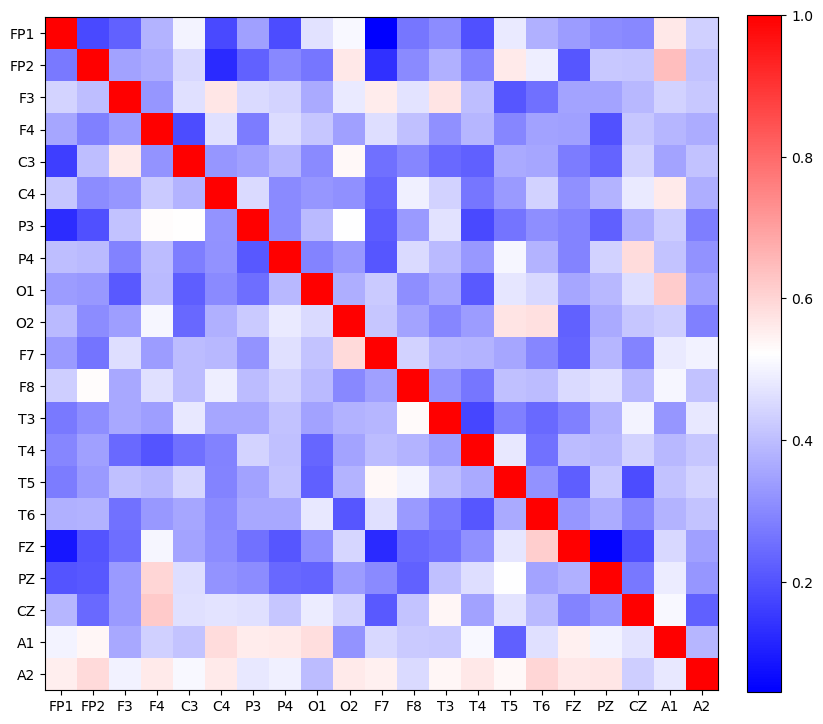

label:  [0]


In [72]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(9.5,9.5))
# create an index for each tick position
my_xticks = ['FP1', 'FP2', 'F3','F4','C3','C4','P3','P4','O1','O2','F7','F8','T3','T4','T5','T6','FZ','PZ','CZ','A1','A2']
x = range(21)

plt.xticks(x, my_xticks)
plt.yticks(x, my_xticks)

im = ax.imshow(train_graphs[20], cmap='bwr', interpolation='nearest')
fig.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)
#fig.savefig("normal1.pdf", bbox_inches='tight')

plt.show()
print("label: ", train_y[20])

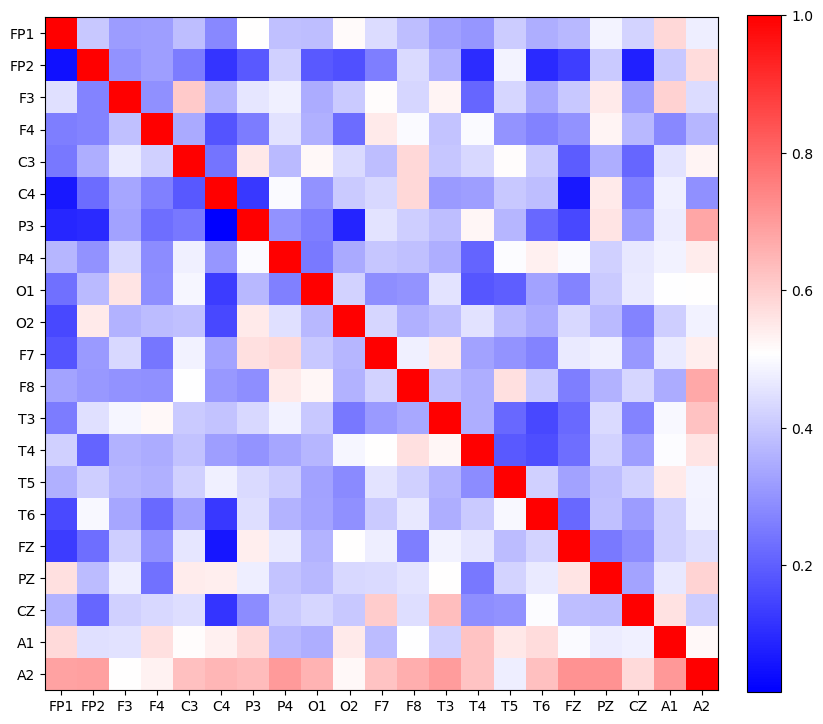

label:  [1]


In [73]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(9.5,9.5))
# create an index for each tick position
my_xticks = ['FP1', 'FP2', 'F3','F4','C3','C4','P3','P4','O1','O2','F7','F8','T3','T4','T5','T6','FZ','PZ','CZ','A1','A2']
x = range(21)

plt.xticks(x, my_xticks)
plt.yticks(x, my_xticks)

im = ax.imshow(train_graphs[0], cmap='bwr', interpolation='nearest')
fig.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)
#fig.savefig("abnormal1.pdf", bbox_inches='tight')

plt.show()

print("label: ", train_y[0])

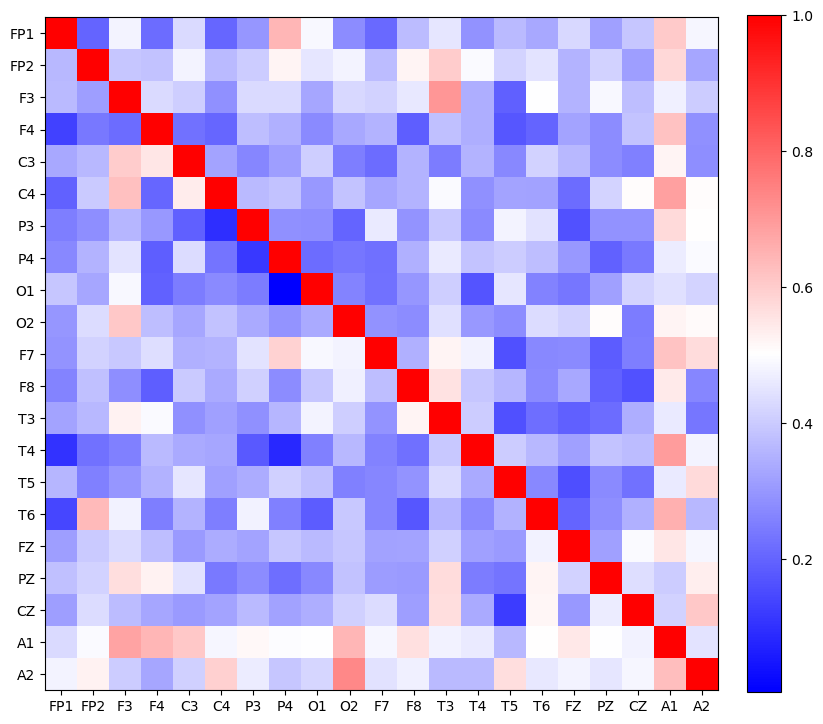

label:  [1]


In [74]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(9.5,9.5))
# create an index for each tick position
my_xticks = ['FP1', 'FP2', 'F3','F4','C3','C4','P3','P4','O1','O2','F7','F8','T3','T4','T5','T6','FZ','PZ','CZ','A1','A2']
x = range(21)

plt.xticks(x, my_xticks)
plt.yticks(x, my_xticks)

im = ax.imshow(train_graphs[6], cmap='bwr', interpolation='nearest')
fig.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)
#fig.savefig("abnormal2.pdf", bbox_inches='tight')

plt.show()

print("label: ", train_y[6])

In [98]:
#np.save("../caueeg_features/conn_data/gc/train_X.npy", train_X)
#np.save("../caueeg_features/conn_data/gc/test_X.npy", test_X)
#np.save("../caueeg_features/conn_data/gc/train_y.npy", train_y)
#np.save("../caueeg_features/conn_data/gc/test_y.npy", test_y)
#np.save("../caueeg_features/conn_data/gc/train_graphs.npy", train_graphs)
#np.save("../caueeg_features/conn_data/gc/test_graphs.npy", test_graphs)

In [75]:
train_X = np.load("../caueeg_features/conn_data/gc/train_X.npy")
test_X = np.load("../caueeg_features/conn_data/gc/test_X.npy")
train_y = np.load("../caueeg_features/conn_data/gc/train_y.npy")
test_y = np.load("../caueeg_features/conn_data/gc/test_y.npy")
train_graphs = np.load("../caueeg_features/conn_data/gc/train_graphs.npy")
test_graphs = np.load("../caueeg_features/conn_data/gc/test_graphs.npy")

In [77]:
import torch

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
import copy

def data_loader(features, graphs, labels, device, batch_size, shuffle=True):
    features, graphs, labels = torch.Tensor(features), torch.Tensor(graphs), torch.Tensor(labels)
    data = torch.utils.data.TensorDataset(features, graphs, labels)
    del features
    del labels
    data_iter = torch.utils.data.DataLoader(data, batch_size, shuffle=shuffle)
    del data
    return data_iter

def standardize_data(train_X, test_X):
 
    train_X_std = copy.deepcopy(train_X)
    test_X_std = copy.deepcopy(test_X)
    
    #train_X_std = train_X_std + 0.00000001
    #test_X_std = test_X_std + 0.00000001
    
    for i in tqdm(range(train_X.shape[1])):
        for j in range(train_X.shape[2]):
            min_ = np.min(train_X[:, i, j])
            max_ = np.max(train_X[:, i, j])
            train_X_std[:, i, j] = (train_X[:, i, j] - min_)/(max_ - min_)
            test_X_std[:, i, j] = (test_X[:, i, j] - min_)/(max_ - min_)

    return train_X_std, test_X_std

In [78]:
train_X.shape, test_X.shape

((1243, 21, 51), (136, 21, 51))

In [79]:
train_X.max(), test_X.max(), train_X.min(), test_X.min()

(40519220791.53532, 37411854744.01686, -9.280505535037554, -9.477938385332227)

In [80]:
train_X, test_X = standardize_data(train_X, test_X)

train_X.shape

100%|████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 468.53it/s]


(1243, 21, 51)

In [81]:
import copy

def uniform(train_graphs, test_graphs):
    out_train = copy.deepcopy(train_graphs)
    out_test = copy.deepcopy(test_graphs)

    min_A = train_graphs.min()
    max_A = train_graphs.max()
    out_train = (train_graphs - min_A)/(max_A - min_A)
    out_test = (test_graphs - min_A)/(max_A - min_A)

    return out_train, out_test

train_graphs, test_graphs = uniform(train_graphs, test_graphs)

In [82]:
train_X.max(), test_X.max(), train_X.min(), test_X.min()

(1.0, 2.6309559118238353, 0.0, -0.8922954610990074)

In [83]:
train_graphs.max(), train_graphs.min()

(1.0, 0.0)

In [84]:
test_graphs.max(), test_graphs.min()

(1.0, 0.0006806849008028711)

In [91]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, auc, roc_auc_score

def evaluate_model(model, loss_func, data_iter):
    model.eval()
    loss_sum, n = 0, 0
    with torch.no_grad():
        for x, A, y in data_iter:
            x = x.float()
            A = A.float()
            y_pred = model(x, A)
            loss = loss_func(y_pred,y)
            loss_sum += loss.item()
            n += 1
        return loss_sum / n
    
def cal_accuracy(model, data_iter):
    ytrue = []
    ypreds = []
    y_score = []
    model.eval()
    with torch.no_grad():
        for x, A, y in data_iter:
            x = x.float()
            A = A.float()
            yhat = model(x, A)
            
            yhat_labels = np.argmax(yhat, -1)
            y_labels = np.argmax(y, -1)
            
            y_score.extend(np.max(F.softmax(yhat, dim=1).numpy(), -1))
            ytrue.extend(list(y_labels.numpy()))
            ypreds.extend([int(yhat_i) for yhat_i in yhat_labels])
    
    return (accuracy_score(ytrue, ypreds), 
            confusion_matrix(ytrue, ypreds), 
            precision_score(ytrue, ypreds,  average='weighted', zero_division=0), 
            recall_score(ytrue, ypreds,  average='weighted', zero_division=0),
            f1_score(ytrue, ypreds,  average='weighted', zero_division=0))

# GC

In [92]:
#%%capture
from tqdm import tqdm
import torch.nn as nn
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import torch
from model import ChebNetGCN


NUM_EPOCHS = 1000
NUM_CHANNELS = 21
NUM_CLASSES = 2
NUM_NODE_FEATURES = 51
BATCH_SIZE = 128
DEVICE = torch.device("cpu")

loss_func = nn.BCEWithLogitsLoss()

all_train_losses = []
all_val_losses = []
all_train_f1 = []
all_val_f1 = []

skf = KFold(n_splits=5, shuffle=True)
skf.get_n_splits(train_X, train_y)

print("Training Model....")
for i, (train_index, val_index) in enumerate(skf.split(train_X, train_y)):
    
    model = ChebNetGCN(NUM_NODE_FEATURES, 32, NUM_CHANNELS, 32, NUM_CLASSES)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_X_subset = train_X[train_index]
    train_y_subset = train_y[train_index]
    train_graphs_subset = train_graphs[train_index]
    val_X = train_X[val_index]
    val_y = train_y[val_index]
    val_graphs_subset = train_graphs[val_index]

    encoder = OneHotEncoder()
    train_y_subset = encoder.fit_transform(train_y_subset).toarray()
    val_y = encoder.transform(val_y).toarray()

    batch_size = 128
    train_iter = data_loader(train_X_subset ,train_graphs_subset, train_y_subset, DEVICE, BATCH_SIZE, shuffle=True)
    val_iter = data_loader(val_X, val_graphs_subset, val_y, DEVICE, BATCH_SIZE, shuffle=False)

    kfold_train_loss = []
    kfold_val_loss = []
    kfold_train_f1 = []
    kfold_val_f1 = []
    for epoch in tqdm(range(1, NUM_EPOCHS + 1)):
        loss_sum, n = 0.0, 0
        model.train()
        for t, (x, A, y) in enumerate(train_iter):
            optimizer.zero_grad()
            x = x.float()
            A = A.float()
            y_pred = model(x, A)
            loss = loss_func(y_pred, y)
            loss_sum += loss#.item()
            loss.backward()
            optimizer.step()

        train_loss = evaluate_model(model, loss_func, train_iter)
        val_loss = evaluate_model(model, loss_func, val_iter)
        train_f1 = cal_accuracy(model, train_iter)[-1]
        val_f1 = cal_accuracy(model, val_iter)[-1]
        kfold_train_loss.append(train_loss)
        kfold_val_loss.append(val_loss)
        kfold_train_f1.append(train_f1)
        kfold_val_f1.append(val_f1)

    all_train_losses.append(kfold_train_loss)
    all_val_losses.append(kfold_val_loss)
    all_train_f1.append(kfold_train_f1)
    all_val_f1.append(kfold_val_f1)

Training Model....


100%|█████████████████████████████████████████████████████████████| 1000/1000 [06:26<00:00,  2.58it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


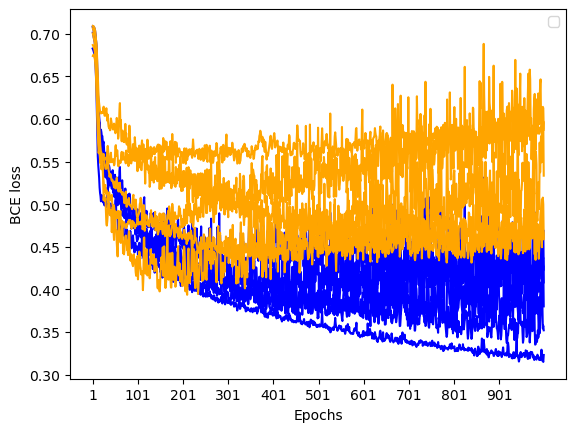

In [93]:
import matplotlib.pyplot as plt

all_val_losses = np.moveaxis(np.array(all_val_losses), 0, 1)
all_train_losses = np.moveaxis(np.array(all_train_losses), 0, 1)
plt.plot(all_train_losses, color='blue')
plt.plot(all_val_losses, color='orange')
plt.xlabel("Epochs")
plt.xticks(range(0, 1000, 100), range(1, 1001, 100))
plt.ylabel("BCE loss")
plt.legend(loc="upper right")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


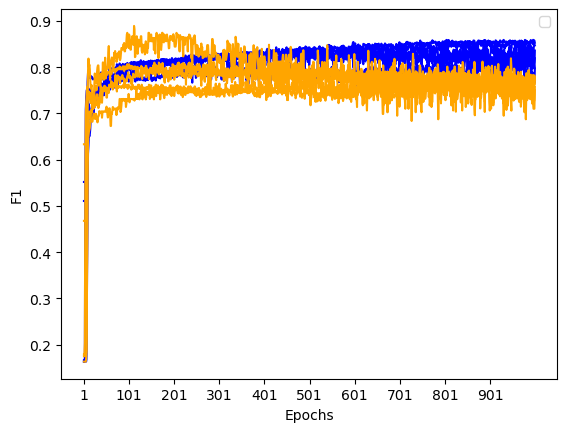

In [94]:
all_val_f1 = np.moveaxis(np.array(all_val_f1), 0, 1)
all_train_f1 = np.moveaxis(np.array(all_train_f1), 0, 1)
plt.plot(all_train_f1, color='blue')
plt.plot(all_val_f1, color='orange')
plt.xlabel("Epochs")
plt.xticks(range(0, 1000, 100), range(1, 1001, 100))
plt.ylabel("F1")
plt.legend(loc="upper right")
plt.show()

In [95]:
#%%capture
from tqdm import tqdm
from tqdm import tqdm
import torch.nn as nn
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import torch
from model import ChebNetGCN


print("Training Model....")
NUM_EPOCHS = 150
NUM_CHANNELS = 21
NUM_CLASSES = 2
NUM_NODE_FEATURES = 51
BATCH_SIZE = 128
DEVICE = torch.device("cpu")

model = ChebNetGCN(NUM_NODE_FEATURES, 32, NUM_CHANNELS, 32, NUM_CLASSES)
loss_func = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
encoder = OneHotEncoder()
train_y_ohe = encoder.fit_transform(train_y).toarray()
test_y_ohe = encoder.fit_transform(test_y).toarray()
    
train_iter = data_loader(train_X , train_graphs, train_y_ohe, DEVICE, BATCH_SIZE, shuffle=True)
test_iter = data_loader(test_X , test_graphs, test_y_ohe, DEVICE, BATCH_SIZE, shuffle=False)
  
for epoch in tqdm(range(1, NUM_EPOCHS + 1)):
    loss_sum, n = 0.0, 0
    model.train()
    for t, (x, A, y) in enumerate(train_iter):
        optimizer.zero_grad()
        x = x.float()
        A = A.float()
        y_pred = model(x, A)
        loss = loss_func(y_pred, y)
        loss_sum += loss
        loss.backward()
        optimizer.step()

Training Model....


100%|███████████████████████████████████████████████████████████████| 150/150 [00:23<00:00,  6.26it/s]


In [96]:
train_acc = cal_accuracy(model, train_iter)
print("Accuracy: ", train_acc[0])
print("Precision: ", train_acc[2])
print("Recall: ", train_acc[3])
print("F1: ", train_acc[4])
print("Confusion Matrix: ", train_acc[1])

Accuracy:  0.8149637972646823
Precision:  0.8116639431366511
Recall:  0.8149637972646823
F1:  0.8087687134763132
Confusion Matrix:  [[255 158]
 [ 72 758]]


In [97]:
test_acc = cal_accuracy(model, test_iter)
print("Accuracy: ", test_acc[0])
print("Precision: ", test_acc[2])
print("Recall: ", test_acc[3])
print("F1: ", test_acc[4])
print("Confusion Matrix: ", test_acc[1])

Accuracy:  0.8382352941176471
Precision:  0.8358455882352942
Recall:  0.8382352941176471
F1:  0.8352014474206787
Confusion Matrix:  [[32 14]
 [ 8 82]]
